
원본데이터 - 로그데이터

원본데이터  - 유저 특성 데이터 - 클러스터링 이후에 결과 집단의 특성을 토대로 비즈니스 전략 수립 가능


            - 비즈니스 전략 데이터


1. 유저 분석을 위한 유저 기준으로 정리된 데이터 - 클러스터링
=> 유저특성지표

row의 단위 : 유저 1명
col의 단위 : 해당 유저에 대한 통계량

EDA해서 나온 요소들을 통합하기

	1) R, F, M
	2) 구매횟수대비 쿠폰사용율
  	3) 평균구매주기






2. 마케팅, 비즈니스 전략을 위한 데이터
=> 경향성 지표


	1) ROAS 지표 = 광고비 대비 매출액(수익)
	   단위기간 중 총 광고비용이 높은 특정 기간
      	   특정 기간 중에 거래량이 많은 집단 특정
	   전략 : 1)결과값을 보고 저희 주관이 들어간 요소

	2) 오프라인 비용으로부터 초래되는 비효율 줄이기
                주장 : 오프라인 마케팅이 효과가 미비하다
                         효과가 상대적으로 좋은 온라인이 오프라인에 맞춰서 조정되는 것이 비효율이다
	   
                오프라인비용 : 일주일단위로 조정 - 비탄력적 요소
                온라인비용 : 하루 단위로 조정 - 탄력적 요소

	    온라인, 오프라인 7일 이동평균 상관관계 = 0.74

	   총 마케팅비용과 총매출 간의 관계        = 0.14
                온라인비용이동평균과 총매출간의 관계 = 0.2












목표1. 클러스터링 해보기
그것을 위한 숙제
1. RFM 간소화하기(클러스터링과의 비교군) => 7개 그룹정도?
    5 * 5 * 2 =
    - 참고 및 평가요소(+ 실루엣 점수)
    1) 클러스터링을 통해 나온 그룹을 어떤 그룹으로 정의할지의 참고사항
    2) 우리만의 클러스터링이 가지고 있는 요소(ex. 우리가 한 클러스터링의 vip는 ㅇㅇㅇ가 RFM에 비해 높다, 대신 ㅇㅇㅇ는 관대하다)
    분류된 고객층 중에서 특정층을 공략하기 => 최종목표
2. Monetary별 가중치 해결하기
3. EDA를 통한 유저 특성 컬럼 추가하기


목표2. ROAS에 요소 추가



## 2023-04-09
### 1. rfm의 컬럼 기준으로 EDA
        - 컬럼들의 분포를 기준으로 bins값을 다시 정한다든지 등

### 2. rfm의 카테고리 컬럼의 차원 축소
        - 최다구매카테고리 : 당일에 결정
        - 지역 : 5개
        - 최다구매월 : 분기로 축소
        - 성별 : 2개

### 3. 클러스터링
        - 적절한 클러스터링 기법과 클러스터의 수, 각 센터로이드의 특징

## 클러스터링을 강화하는 방향
### 1. 유저 중심 컬럼

In [1]:
import numpy as np
import pandas as pd

import datetime as dt
import time
from tqdm import tqdm

import matplotlib.pyplot as plt
import seaborn as sns
plt.rc('font', family='NanumBarunGothic')
plt.rcParams['axes.unicode_minus'] = False

import re

import warnings
warnings.filterwarnings('ignore')

In [2]:
# !sudo apt-get install -y fonts-nanum
# !sudo fc-cache -fv
# !rm ~/.cache/matplotlib -rf

In [2]:
df1 = pd.read_csv('/content/Onlinesales_info.csv')
df2 = pd.read_csv('/content/Customer_info.csv')
df3 = pd.read_csv('/content/Discount_info.csv')
df4 = pd.read_csv('/content/Marketing_info.csv')
df5 = pd.read_csv('/content/Tax_info.csv')

In [3]:
df = pd.merge(df1, df2, how='left', on='고객ID')
df = pd.merge(df, df5, how='left', on='제품카테고리')

df['거래날짜'] = pd.to_datetime(df['거래날짜'])
df['월'] = df['거래날짜'].dt.month

In [4]:
def month_shift(x):
    dict = {1:'Jan',
            2:'Feb',
            3:'Mar',
            4:'Apr',
            5:'May',
            6:'Jun',
            7:'Jul',
            8:'Aug',
            9:'Sep',
            10:'Oct',
            11:'Nov',
            12:'Dec'}

    return dict[x]

In [5]:
df['월'] = df['월'].apply(month_shift)

In [6]:
df = pd.merge(df, df3, how='left', on=['월', '제품카테고리'])

In [7]:
df4['날짜'] = pd.to_datetime(df4['날짜'])
df = pd.merge(df, df4, how='left', left_on='거래날짜', right_on='날짜')

df = df.drop('날짜', axis=1)

In [8]:
df.head()

고객ID              거래ID       거래날짜          제품ID    제품카테고리  수량    평균금액  \
0  USER_1358  Transaction_0000 2019-01-01  Product_0981  Nest-USA   1  153.71   
1  USER_1358  Transaction_0001 2019-01-01  Product_0981  Nest-USA   1  153.71   
2  USER_1358  Transaction_0002 2019-01-01  Product_0904    Office   1    2.05   
3  USER_1358  Transaction_0003 2019-01-01  Product_0203   Apparel   5   17.53   
4  USER_1358  Transaction_0003 2019-01-01  Product_0848      Bags   1   16.50   

   배송료      쿠폰상태 성별     고객지역  가입기간   GST    월    쿠폰코드   할인율  오프라인비용   온라인비용  
0  6.5      Used  남  Chicago    12  0.10  Jan  ELEC10  10.0    4500  2424.5  
1  6.5      Used  남  Chicago    12  0.10  Jan  ELEC10  10.0    4500  2424.5  
2  6.5      Used  남  Chicago    12  0.10  Jan   OFF10  10.0    4500  2424.5  
3  6.5  Not Used  남  Chicago    12  0.18  Jan  SALE10  10.0    4500  2424.5  
4  6.5      Used  남  Chicago    12  0.18  Jan   AIO10  10.0    4500  2424.5

In [9]:
df.to_csv('merge.csv')

In [10]:
df.head()

고객ID              거래ID       거래날짜          제품ID    제품카테고리  수량    평균금액  \
0  USER_1358  Transaction_0000 2019-01-01  Product_0981  Nest-USA   1  153.71   
1  USER_1358  Transaction_0001 2019-01-01  Product_0981  Nest-USA   1  153.71   
2  USER_1358  Transaction_0002 2019-01-01  Product_0904    Office   1    2.05   
3  USER_1358  Transaction_0003 2019-01-01  Product_0203   Apparel   5   17.53   
4  USER_1358  Transaction_0003 2019-01-01  Product_0848      Bags   1   16.50   

   배송료      쿠폰상태 성별     고객지역  가입기간   GST    월    쿠폰코드   할인율  오프라인비용   온라인비용  
0  6.5      Used  남  Chicago    12  0.10  Jan  ELEC10  10.0    4500  2424.5  
1  6.5      Used  남  Chicago    12  0.10  Jan  ELEC10  10.0    4500  2424.5  
2  6.5      Used  남  Chicago    12  0.10  Jan   OFF10  10.0    4500  2424.5  
3  6.5  Not Used  남  Chicago    12  0.18  Jan  SALE10  10.0    4500  2424.5  
4  6.5      Used  남  Chicago    12  0.18  Jan   AIO10  10.0    4500  2424.5

In [12]:
user_region = pd.DataFrame(df.groupby('고객ID')['고객지역'].apply(lambda x: x.value_counts().idxmax()))

In [11]:
mode_category = pd.DataFrame(df.groupby('고객ID')['제품카테고리'].apply(lambda x: x.value_counts(ascending=False).index.values))
mode_category['first'] = mode_category['제품카테고리'].apply(lambda x: x[0])
mode_category['Second'] = mode_category['제품카테고리'].apply(lambda x: x[1] if len(x) >= 2 else 'None')
mode_category['Third'] = mode_category['제품카테고리'].apply(lambda x: x[2] if len(x) >= 3 else 'None')



mode_category

제품카테고리     first  \
고객ID                                                                     
USER_0000                                  [Apparel, Office]   Apparel   
USER_0001  [Nest-USA, Apparel, Office, Bags, Drinkware, N...  Nest-USA   
USER_0002  [Office, Lifestyle, Apparel, Drinkware, Bags, ...    Office   
USER_0003         [Apparel, Nest-USA, Nest-Canada, Headgear]   Apparel   
USER_0004  [Apparel, Office, Nest-USA, Lifestyle, Drinkwa...   Apparel   
...                                                      ...       ...   
USER_1463  [Apparel, Notebooks & Journals, More Bags, Dri...   Apparel   
USER_1464  [Apparel, Nest-USA, Office, Notebooks & Journa...   Apparel   
USER_1465                                  [Apparel, Office]   Apparel   
USER_1466                                         [Nest-USA]  Nest-USA   
USER_1467  [Apparel, Nest-USA, Office, Gift Cards, Lifest...   Apparel   

                         Second        Third  
고객ID                                          
USER_0000                Office         None  
USER_0001               Apparel       Office  
USER_0002             Lifestyle      Apparel  
USER_0003              Nest-USA  Nest-Canada  
USER_0004                Office     Nest-USA  
...                         ...          ...  
USER_1463  Notebooks & Journals    More Bags  
USER_1464              Nest-USA       Office  
USER_1465                Office         None  
USER_1466                  None         None  
USER_1467              Nest-USA       Office  

[1468 rows x 4 columns]

In [13]:
df['쿠폰코드'] = df['쿠폰코드'].fillna(np.nan)
df['할인율'] = df['할인율'].fillna(0)

In [14]:
def true_discount(x):
    if x == 'Used':
        return 1
    else:
        return 0

In [15]:
df['true_discount'] = df['쿠폰상태'].apply(true_discount)

In [16]:
df.head()

고객ID              거래ID       거래날짜          제품ID    제품카테고리  수량    평균금액  \
0  USER_1358  Transaction_0000 2019-01-01  Product_0981  Nest-USA   1  153.71   
1  USER_1358  Transaction_0001 2019-01-01  Product_0981  Nest-USA   1  153.71   
2  USER_1358  Transaction_0002 2019-01-01  Product_0904    Office   1    2.05   
3  USER_1358  Transaction_0003 2019-01-01  Product_0203   Apparel   5   17.53   
4  USER_1358  Transaction_0003 2019-01-01  Product_0848      Bags   1   16.50   

   배송료      쿠폰상태 성별     고객지역  가입기간   GST    월    쿠폰코드   할인율  오프라인비용   온라인비용  \
0  6.5      Used  남  Chicago    12  0.10  Jan  ELEC10  10.0    4500  2424.5   
1  6.5      Used  남  Chicago    12  0.10  Jan  ELEC10  10.0    4500  2424.5   
2  6.5      Used  남  Chicago    12  0.10  Jan   OFF10  10.0    4500  2424.5   
3  6.5  Not Used  남  Chicago    12  0.18  Jan  SALE10  10.0    4500  2424.5   
4  6.5      Used  남  Chicago    12  0.18  Jan   AIO10  10.0    4500  2424.5   

   true_discount  
0              1  
1              1  
2              1  
3              0  
4              1

In [17]:

# 카테고리별 주문량 계산
category_order_volume = pd.DataFrame(df.groupby('제품카테고리').size().reset_index(name='주문건수'))

# 카테고리별 총 주문 수량 계산
category_order_quantity = pd.DataFrame(df.groupby('제품카테고리')['수량'].sum().reset_index(name='총주문수량'))


category_order_total = pd.merge(category_order_volume, category_order_quantity,  how='left', on='제품카테고리')
category_order_total['평균주문수량'] = category_order_total['총주문수량'] / category_order_total['주문건수']
category_order_total['주문건수비율(%)'] = (category_order_total['주문건수'] / category_order_total['주문건수'].sum()).round(4) * 100

print('                            제품카테고별 주문 정보')
category_order_total.sort_values('주문건수', ascending=False).reset_index(drop=True)

                            제품카테고별 주문 정보


제품카테고리   주문건수  총주문수량     평균주문수량  주문건수비율(%)
0                Apparel  18126  32438   1.789584      34.25
1               Nest-USA  14013  21430   1.529294      26.48
2                 Office   6513  88383  13.570244      12.31
3              Drinkware   3483  30501   8.757106       6.58
4              Lifestyle   3092  24881   8.046895       5.84
5                   Nest   2198   2837   1.290719       4.15
6                   Bags   1882  15273   8.115303       3.56
7               Headgear    771   3533   4.582361       1.46
8   Notebooks & Journals    749   9556  12.758344       1.42
9                   Waze    554   1144   2.064982       1.05
10           Nest-Canada    317    469   1.479495       0.60
11               Bottles    268   2090   7.798507       0.51
12           Accessories    234   1097   4.688034       0.44
13                   Fun    160    834   5.212500       0.30
14            Gift Cards    159    206   1.295597       0.30
15            Housewares    122   2484  20.360656       0.23
16                Google    105    575   5.476190       0.20
17             Backpacks     89    113   1.269663       0.17
18             More Bags     46    144   3.130435       0.09
19               Android     43     45   1.046512       0.08

Text(0.5, 1.0, '카테고리별 평균주문 분포')

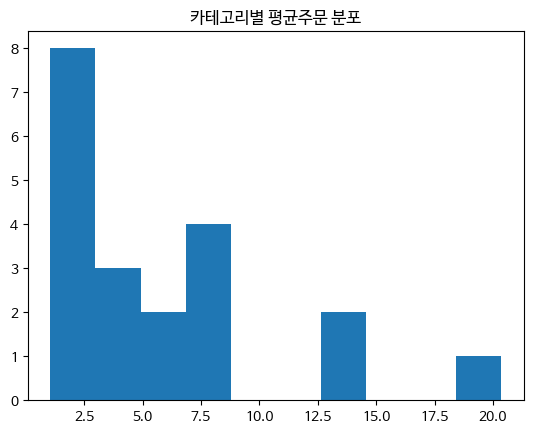

In [19]:
plt.hist(category_order_total['평균주문수량'])
plt.title('카테고리별 평균주문 분포')

In [18]:
coupon_use_rate = df.groupby(['제품카테고리', '쿠폰상태']).size().unstack(fill_value=0)
coupon_use_rate['Clicked_rate'] = coupon_use_rate['Clicked'] / coupon_use_rate.sum(axis=1)
coupon_use_rate['Not Used_rate'] = coupon_use_rate['Not Used'] / coupon_use_rate.sum(axis=1)
coupon_use_rate['Used_rate'] = coupon_use_rate['Used'] / coupon_use_rate.sum(axis=1)

print('                  제품카테고별 쿠폰상태 비율(%)')
coupon_use_rate= coupon_use_rate[['Used_rate', 'Clicked_rate', 'Not Used_rate']].round(4) * 100


coupon_use_rate['marketing_effect'] = coupon_use_rate['Used_rate']  / (coupon_use_rate['Used_rate'] + coupon_use_rate['Clicked_rate'])


coupon_use_rate['marketing_effect'] = coupon_use_rate['marketing_effect'].round(4) * 100

coupon_use_rate.sort_values('marketing_effect', ascending=False)

                  제품카테고별 쿠폰상태 비율(%)


쿠폰상태                  Used_rate  Clicked_rate  Not Used_rate  marketing_effect
제품카테고리                                                                        
Lifestyle                 35.60         49.45          14.94             41.86
More Bags                 38.62         54.35           6.45             41.54
Gift Cards                35.08         50.94          13.79             40.78
Office                    34.54         50.59          14.86             40.57
Apparel                   33.96         50.88          15.15             40.03
Drinkware                 33.33         50.30          16.36             39.85
Notebooks & Journals      34.28         51.94          13.74             39.76
Nest-USA                  33.62         50.96          15.41             39.75
Waze                      33.17         50.72          16.05             39.54
Bags                      33.20         51.65          15.14             39.13
Nest                      32.75         51.27          15.97             38.98
Headgear                  33.17         52.01          14.78             38.94
Fun                       32.36         51.88          15.57             38.41
Accessories               32.81         53.42          13.64             38.05
Bottles                   30.52         51.49          17.88             37.21
Backpacks                 30.10         52.81          16.75             36.30
Google                    27.43         48.57          23.70             36.09
Nest-Canada               29.90         55.21          14.80             35.13
Housewares                29.34         55.74          14.69             34.49
Android                   22.85         53.49          22.97             29.93

In [19]:
gender_rate = df.groupby(['제품카테고리', '성별']).size().unstack(fill_value=0)
gender_rate = pd.merge(gender_rate, category_order_total[['제품카테고리', '주문건수']], how='left', on='제품카테고리')
gender_rate = gender_rate.sort_values('주문건수', ascending=False)
gender_rate['Male'] = gender_rate['남'] / gender_rate['주문건수']
gender_rate['Female'] = gender_rate['여'] / gender_rate['주문건수']



print('       제품카테고별 성별 비율(%)')
gender_rate = gender_rate[['제품카테고리', 'Male', 'Female']].set_index('제품카테고리').round(4) * 100
gender_rate.sort_values('Female', ascending=False)

       제품카테고별 성별 비율(%)


Male  Female
제품카테고리                             
Gift Cards            25.16   74.84
More Bags             30.43   69.57
Headgear              34.63   65.37
Bottles               35.07   64.93
Office                35.85   64.15
Bags                  37.19   62.81
Apparel               37.36   62.64
Drinkware             37.38   62.62
Nest-Canada           37.85   62.15
Fun                   38.12   61.88
Lifestyle             38.29   61.71
Nest-USA              38.33   61.67
Accessories           38.89   61.11
Android               39.53   60.47
Nest                  39.67   60.33
Google                40.00   60.00
Housewares            40.16   59.84
Waze                  40.97   59.03
Notebooks & Journals  42.32   57.68
Backpacks             48.31   51.69

In [20]:
df.columns

Index(['고객ID', '거래ID', '거래날짜', '제품ID', '제품카테고리', '수량', '평균금액', '배송료', '쿠폰상태',
       '성별', '고객지역', '가입기간', 'GST', '월', '쿠폰코드', '할인율', '오프라인비용', '온라인비용',
       'true_discount'],
      dtype='object')

고객지역 - 서인
월 - 경화
가입기간 - 정식

거래ID	     - F(count)
거래날짜     - 기준(날짜별 금액), 고유거래일(nunique)
제품ID	    -
제품카테고리 - 최다구매카테고리
수량        - 평균수량
평균금액    - 수량, 할인율, GST 배송료 등과 결합하여 총금액
배송료	    - (총금액 계산을 위한 평균 배송료)
쿠폰상태    - 구매횟수대비쿠폰사용율, 총할인금액, clicked 비율
성별	    - 성별은 성별
고객지역	- 지역은 지역
가입기간	- 기간은 기간
GST	       - 총납세액
월	       - 최다구매월, 해당월의 거래수
할인율	    - 총금액 계산시에 사용, 평균 할인율(not used = 0)

4개씩 분담해서 만들어오기

### 1. raw 데이터 join만 해놓은   df                                
                    
- ~~총금액(row단위) ~~                        
- ~~(총금액 계산을 위한 평균 배송료)  ~~      
- ~~납세액(row)~~

### 2. user별로 groupby한 rfm
- ~~F(count)~~
- 고유거래일(nunique)
- ~~최다구매카테고리~~    
- 평균수량
- ~~총금액(유저단위)~~
- ~~구매횟수대비쿠폰사용율~~
- 총할인금액
- clicked 비율
- 성별, 지역, 기간
- ~~총납세액(유저단위)~~
- 최다구매월
- 해당월의 거래수
- 평균 할인율(not used = 0)



1) 준범                                                               
- 총금액(유저단위)                     
- 총금액(row단위)                    
- 납세액(row)                           
- (총금액 계산을 위한 평균 배송료)        
- 총납세액(유저단위)

2) 정식

- 고유거래일(nunique)
- 평균수량

3) 서인
- 총할인금액
- clicked 비율
- 성별, 지역, 기간

4) 경화
- 최다구매월
- 해당월의 거래수
- 평균 할인율(not used = 0)

In [21]:
transfer = pd.DataFrame(df.groupby(['고객ID', '거래ID'])['배송료'].mean() / df.groupby(['고객ID', '거래ID'])['제품카테고리'].count())
transfer = transfer.reset_index()
transfer = transfer.rename(columns={0:'평균배송료'})


In [22]:
df = pd.merge(df, transfer, how='left', on=['고객ID', '거래ID'])

In [23]:
df['납세액'] = df['수량'] * df['평균금액'] * df['GST']

In [24]:
df['총금액'] = (df['평균금액'] * ((100 - (df['true_discount'] * df['할인율'])) / 100) * df['수량']) + df['평균배송료'] + df['납세액']  # 고객이 최종적으로 부담하는 금액


In [25]:
today_date = dt.datetime(2019,12,31)
rfm = pd.DataFrame(df.groupby('고객ID').agg({'거래ID':'nunique',
                          '총금액':'sum',
                          '거래날짜': lambda x: (today_date - x.max()).days,
                          '납세액':'sum'}))

rfm = rfm.rename(columns={'거래ID':'Frequency',
                          '총금액':'Monetary',
                          '거래날짜':'Recency',
                          '납세액':'총납세액'})
rfm = rfm[['Recency', 'Frequency', 'Monetary', '총납세액']]

In [ ]:
temp = pd.DataFrame(df.groupby(['고객ID', '거래ID'])['수량'].sum()).reset_index()

mean_purchase_quantity = temp.groupby('고객ID')['수량'].mean().reset_index()
# 'rfm' 테이블에 고객ID를 기준으로 merge
rfm = pd.merge(rfm, mean_purchase_quantity, on='고객ID', how='left')

# 컬럼명 변경
rfm.rename(columns={'수량': '평균구매수량'}, inplace=True)
rfm.head()

In [ ]:
kh_mon = df.groupby(['고객ID', '월'])['거래ID'].nunique().reset_index(name='구매횟수')
kh_mon = kh_mon.loc[kh_mon.groupby('고객ID')['구매횟수'].idxmax()]
kh_mon = kh_mon.rename(columns={'월':'최다구매월'})


df['real_discount'] = df['할인율'] * df['true_discount']
dis_kh = df.groupby('고객ID')['real_discount'].mean().reset_index()
dis_kh['real_discount'] = dis_kh['real_discount'].round(2)
dis_kh = dis_kh.rename(columns={'real_discount':'평균할인율'})

rfm= pd.merge(rfm,kh_mon, how='left',on='고객ID')
rfm= pd.merge(rfm,dis_kh, how='left',on='고객ID')
rfm

In [ ]:
unique_transaction_date = df.groupby('고객ID')['거래날짜'].nunique()

# 'rfm' 테이블에 고객ID를 기준으로 merge
rfm = pd.merge(rfm, unique_transaction_date, on='고객ID', how='left')

# 컬럼명 변경
rfm.rename(columns={'거래날짜': '고유거래일수'}, inplace=True)
rfm.head()

In [30]:
last_date = dt.datetime(2019, 12, 31)

date = df.sort_values(['고객ID', '거래날짜'])[['고객ID', '거래날짜']].drop_duplicates()
date['구매주기'] = date.groupby('고객ID')['거래날짜'].diff().fillna(last_date-date['거래날짜'])

avg_buying = pd.DataFrame(date.groupby('고객ID')['구매주기'].mean()).reset_index()


rfm = pd.merge(rfm, avg_buying, how='left', on='고객ID').rename(columns={'구매주기':'평균구매주기'})

rfm['평균구매주기'] = rfm['평균구매주기'].dt.days

In [31]:
# 클러스터링에 사용할 유저 특성 테이블
rfm = pd.merge(rfm, mode_category, how='left', on='고객ID')

In [ ]:
rfm = rfm.rename(columns={'제품카테고리':'최다구매카테고리',
                          '구매횟수':'당월구매횟수',
                          'first':'First_category',
                          'Second':'Second_category',
                          'Third':'Third_category'})
rfm = rfm.drop('최다구매카테고리', axis=1)
rfm

In [33]:

df_1=pd.DataFrame(data=df,columns=['고객ID','성별','고객지역','가입기간'])
df_1=df_1.drop_duplicates()
df_1=df_1.reset_index(drop=True)
rfm=pd.merge(rfm,df_1,on='고객ID')

df['df총할인금액']=df['수량']*df['평균금액']*df['true_discount']*(0.01*df['할인율'])
for_rfm=df.groupby('고객ID')['df총할인금액'].sum()
for_rfm=pd.DataFrame(for_rfm)
rfm=pd.merge(rfm,for_rfm,on='고객ID')
rfm.head(10)

clicked = pd.DataFrame(df.groupby('고객ID')['쿠폰상태'].value_counts() / df.groupby('고객ID')['쿠폰상태'].count())
clicked_core = pd.DataFrame(clicked.loc[([i if i != 0 else 0 for i in df['고객ID'].unique()], 'Clicked'), :].sort_index())
rfm=pd.merge(rfm,clicked_core,on='고객ID', how='left').fillna(0).rename(columns={'df총할인금액':'총할인금액', '쿠폰상태':'Clicked_ratio'})

In [34]:
coupon = pd.DataFrame(df.groupby('고객ID')['쿠폰상태'].value_counts() / df.groupby('고객ID')['쿠폰상태'].count())

coupon_core = pd.DataFrame(coupon.loc[([i if i != 0 else 0 for i in df['고객ID'].unique()], 'Used'), :].sort_index())


rfm = pd.merge(rfm, coupon_core, how='left', on='고객ID').fillna(0)
rfm = rfm.rename(columns={'0_x':'Used_ratio'})
rfm = rfm.rename(columns={'0_y':'Clicked_ratio'})

In [35]:
rfm['Used_ratio_per_F'] = rfm['Used_ratio'] / rfm['Frequency']
rfm['Clicked_ratio_per_F'] = rfm['Clicked_ratio'] / rfm['Frequency']

In [37]:
pd.set_option('display.max_columns', None)
df.head(3)

고객ID              거래ID       거래날짜          제품ID    제품카테고리  수량    평균금액  \
0  USER_1358  Transaction_0000 2019-01-01  Product_0981  Nest-USA   1  153.71   
1  USER_1358  Transaction_0001 2019-01-01  Product_0981  Nest-USA   1  153.71   
2  USER_1358  Transaction_0002 2019-01-01  Product_0904    Office   1    2.05   

   배송료  쿠폰상태 성별     고객지역  가입기간  GST    월    쿠폰코드   할인율  오프라인비용   온라인비용  \
0  6.5  Used  남  Chicago    12  0.1  Jan  ELEC10  10.0    4500  2424.5   
1  6.5  Used  남  Chicago    12  0.1  Jan  ELEC10  10.0    4500  2424.5   
2  6.5  Used  남  Chicago    12  0.1  Jan   OFF10  10.0    4500  2424.5   

   true_discount  평균배송료     납세액     총금액  real_discount  df총할인금액  
0              1    6.5  15.371  160.21           10.0   15.371  
1              1    6.5  15.371  160.21           10.0   15.371  
2              1    6.5   0.205    8.55           10.0    0.205

In [39]:
# 고객별 최초 구매일
first_purchase_date = df.groupby('고객ID')['거래날짜'].min()

# 추가 구매 데이터만 가져오기
additional_purchase = df[df['거래날짜'] > first_purchase_date[df['고객ID']].values]

# 고객별 추가 구매 횟수 계산
additional_purchase_count = additional_purchase.groupby('고객ID').size().reset_index(name='추가구매횟수')

rfm = rfm.merge(additional_purchase_count, on='고객ID', how='left')

In [71]:
rfm[rfm['고객ID'] == 'USER_1465']

고객ID  Recency  Frequency  Monetary     총납세액  평균구매수량 최다구매월  당월구매횟수  \
1465  USER_1465      194          2  128.5234  18.0264     5.0   Apr       1   

      평균할인율  고유거래일수  평균구매주기 First_category Second_category Third_category 성별  \
1465   3.75       2     173        Apparel          Office           None  남   

         고객지역  가입기간  총할인금액  Used_ratio  Clicked_ratio  Used_ratio_per_F  \
1465  Chicago    25  3.563         0.5          0.375              0.25   

      Clicked_ratio_per_F  추가구매횟수  구매카테고리수  
1465               0.1875     1.0        2

In [72]:
df[df['고객ID'] == 'USER_1465']

고객ID               거래ID       거래날짜          제품ID   제품카테고리  수량  \
12242  USER_1465   Transaction_5988 2019-04-05  Product_0005  Apparel   1   
12243  USER_1465   Transaction_5988 2019-04-05  Product_0030  Apparel   1   
12244  USER_1465   Transaction_5988 2019-04-05  Product_0034  Apparel   1   
12245  USER_1465   Transaction_5988 2019-04-05  Product_0054  Apparel   1   
12246  USER_1465   Transaction_5988 2019-04-05  Product_0073  Apparel   1   
12247  USER_1465   Transaction_5988 2019-04-05  Product_0090  Apparel   2   
12248  USER_1465   Transaction_5988 2019-04-05  Product_0184   Office   2   
23124  USER_1465  Transaction_10833 2019-06-20  Product_0506  Apparel   1   

        평균금액  배송료      쿠폰상태 성별     고객지역  가입기간   GST    월    쿠폰코드   할인율  \
12242  15.99  6.5  Not Used  남  Chicago    25  0.18  Apr  SALE10  10.0   
12243  10.63  6.5   Clicked  남  Chicago    25  0.18  Apr  SALE10  10.0   
12244  10.63  6.5   Clicked  남  Chicago    25  0.18  Apr  SALE10  10.0   
12245  11.19  6.5      Used  남  Chicago    25  0.18  Apr  SALE10  10.0   
12246  13.99  6.5   Clicked  남  Chicago    25  0.18  Apr  SALE10  10.0   
12247  10.63  6.5      Used  남  Chicago    25  0.18  Apr  SALE10  10.0   
12248   1.59  6.5      Used  남  Chicago    25  0.10  Apr   OFF10  10.0   
23124  14.69  6.0   Clicked  남  Chicago    25  0.18  Jun  SALE30  30.0   

       오프라인비용    온라인비용  true_discount     평균배송료     납세액        총금액  \
12242    2500  2342.68              0  0.928571  2.8782  19.796771   
12243    2500  2342.68              0  0.928571  1.9134  13.471971   
12244    2500  2342.68              0  0.928571  1.9134  13.471971   
12245    2500  2342.68              1  0.928571  2.0142  13.013771   
12246    2500  2342.68              0  0.928571  2.5182  17.436771   
12247    2500  2342.68              1  0.928571  3.8268  23.889371   
12248    2500  2342.68              1  0.928571  0.3180   4.108571   
23124    3500  1019.59              0  6.000000  2.6442  23.334200   

       real_discount  df총할인금액  
12242            0.0    0.000  
12243            0.0    0.000  
12244            0.0    0.000  
12245           10.0    1.119  
12246            0.0    0.000  
12247           10.0    2.126  
12248           10.0    0.318  
23124            0.0    0.000

In [63]:
rfm['추가구매횟수'].describe()

count    734.000000
mean      36.734332
std       60.496730
min        1.000000
25%        7.000000
50%       20.000000
75%       44.000000
max      694.000000
Name: 추가구매횟수, dtype: float64

In [64]:
# 각 고객별로 구매한 제품 카테고리 수 계산
category_count = df.groupby('고객ID')['제품카테고리'].nunique().reset_index()
category_count.columns = ['고객ID', '구매카테고리수']

# rfm 데이터프레임에 구매 카테고리 수 컬럼 추가
rfm = rfm.merge(category_count, on='고객ID', how='left')

In [65]:
rfm

고객ID  Recency  Frequency    Monetary       총납세액     평균구매수량 최다구매월  \
0     USER_0000      107          1    101.3912     4.6982   3.000000   Sep   
1     USER_0001       59         31  15407.7190  2067.9070  11.032258   Nov   
2     USER_0002       73          8   1596.0858   203.6008  26.125000   Jun   
3     USER_0003       17         11   1438.5072   148.2642   1.909091   Dec   
4     USER_0004      107         13   1541.9718   151.7598   4.307692   Sep   
...         ...      ...        ...         ...        ...        ...   ...   
1463  USER_1463      270          3    678.7202    51.2202  15.333333   Apr   
1464  USER_1464       87         19   2631.9586   277.1706   7.421053   Aug   
1465  USER_1465      194          2    128.5234    18.0264   5.000000   Apr   
1466  USER_1466       69          1    333.8000    29.8000   2.000000   Oct   
1467  USER_1467       82         53   7000.0783   583.1923   2.924528   Oct   

      당월구매횟수  평균할인율  고유거래일수  평균구매주기 First_category       Second_category  \
0          1  30.00       1     107        Apparel                Office   
1         18   8.00       3     168       Nest-USA               Apparel   
2          4  11.74       2     155         Office             Lifestyle   
3         11  10.59       1      17        Apparel              Nest-USA   
4         13   9.17       1     107        Apparel                Office   
...      ...    ...     ...     ...            ...                   ...   
1463       3   4.29       1     270        Apparel  Notebooks & Journals   
1464      10   9.25       3      99        Apparel              Nest-USA   
1465       1   3.75       2     173        Apparel                Office   
1466       1   0.00       1      69       Nest-USA                  None   
1467      31   3.73       2     114        Apparel              Nest-USA   

     Third_category 성별        고객지역  가입기간    총할인금액  Used_ratio  Clicked_ratio  \
0              None  여    New York    31    9.297    0.000000       1.000000   
1            Office  남    New York    20  781.548    0.433333       0.333333   
2           Apparel  남  California    39  130.705    0.478261       0.478261   
3       Nest-Canada  남  California    25  152.217    0.470588       0.352941   
4          Nest-USA  여     Chicago    31  206.748    0.472222       0.305556   
...             ... ..         ...   ...      ...         ...            ...   
1463      More Bags  여  California     5   11.190    0.428571       0.428571   
1464         Office  남    New York    43  230.312    0.525000       0.400000   
1465           None  남     Chicago    25    3.563    0.500000       0.375000   
1466           None  여     Chicago    47    0.000    0.000000       0.000000   
1467         Office  여  New Jersey    36  283.754    0.500000       0.372549   

      Used_ratio_per_F  Clicked_ratio_per_F  추가구매횟수  구매카테고리수  
0             0.000000             1.000000     NaN        2  
1             0.013978             0.010753    29.0       10  
2             0.059783             0.059783     6.0        6  
3             0.042781             0.032086     NaN        4  
4             0.036325             0.023504     NaN        7  
...                ...                  ...     ...      ...  
1463          0.142857             0.142857     NaN        4  
1464          0.027632             0.021053    29.0       11  
1465          0.250000             0.187500     1.0        2  
1466          0.000000             0.000000     NaN        1  
1467          0.009434             0.007029    45.0       13  

[1468 rows x 24 columns]

In [ ]:
for col in rfm[['Recency','Frequency','Monetary', '평균구매수량', '당월구매횟수','평균할인율','고유거래일수','Used_ratio','평균구매주기', '가입기간', '총할인금액', 'Clicked_ratio']].columns:
    plt.hist(rfm[col])
    plt.title(col, fontsize=14)
    plt.show()

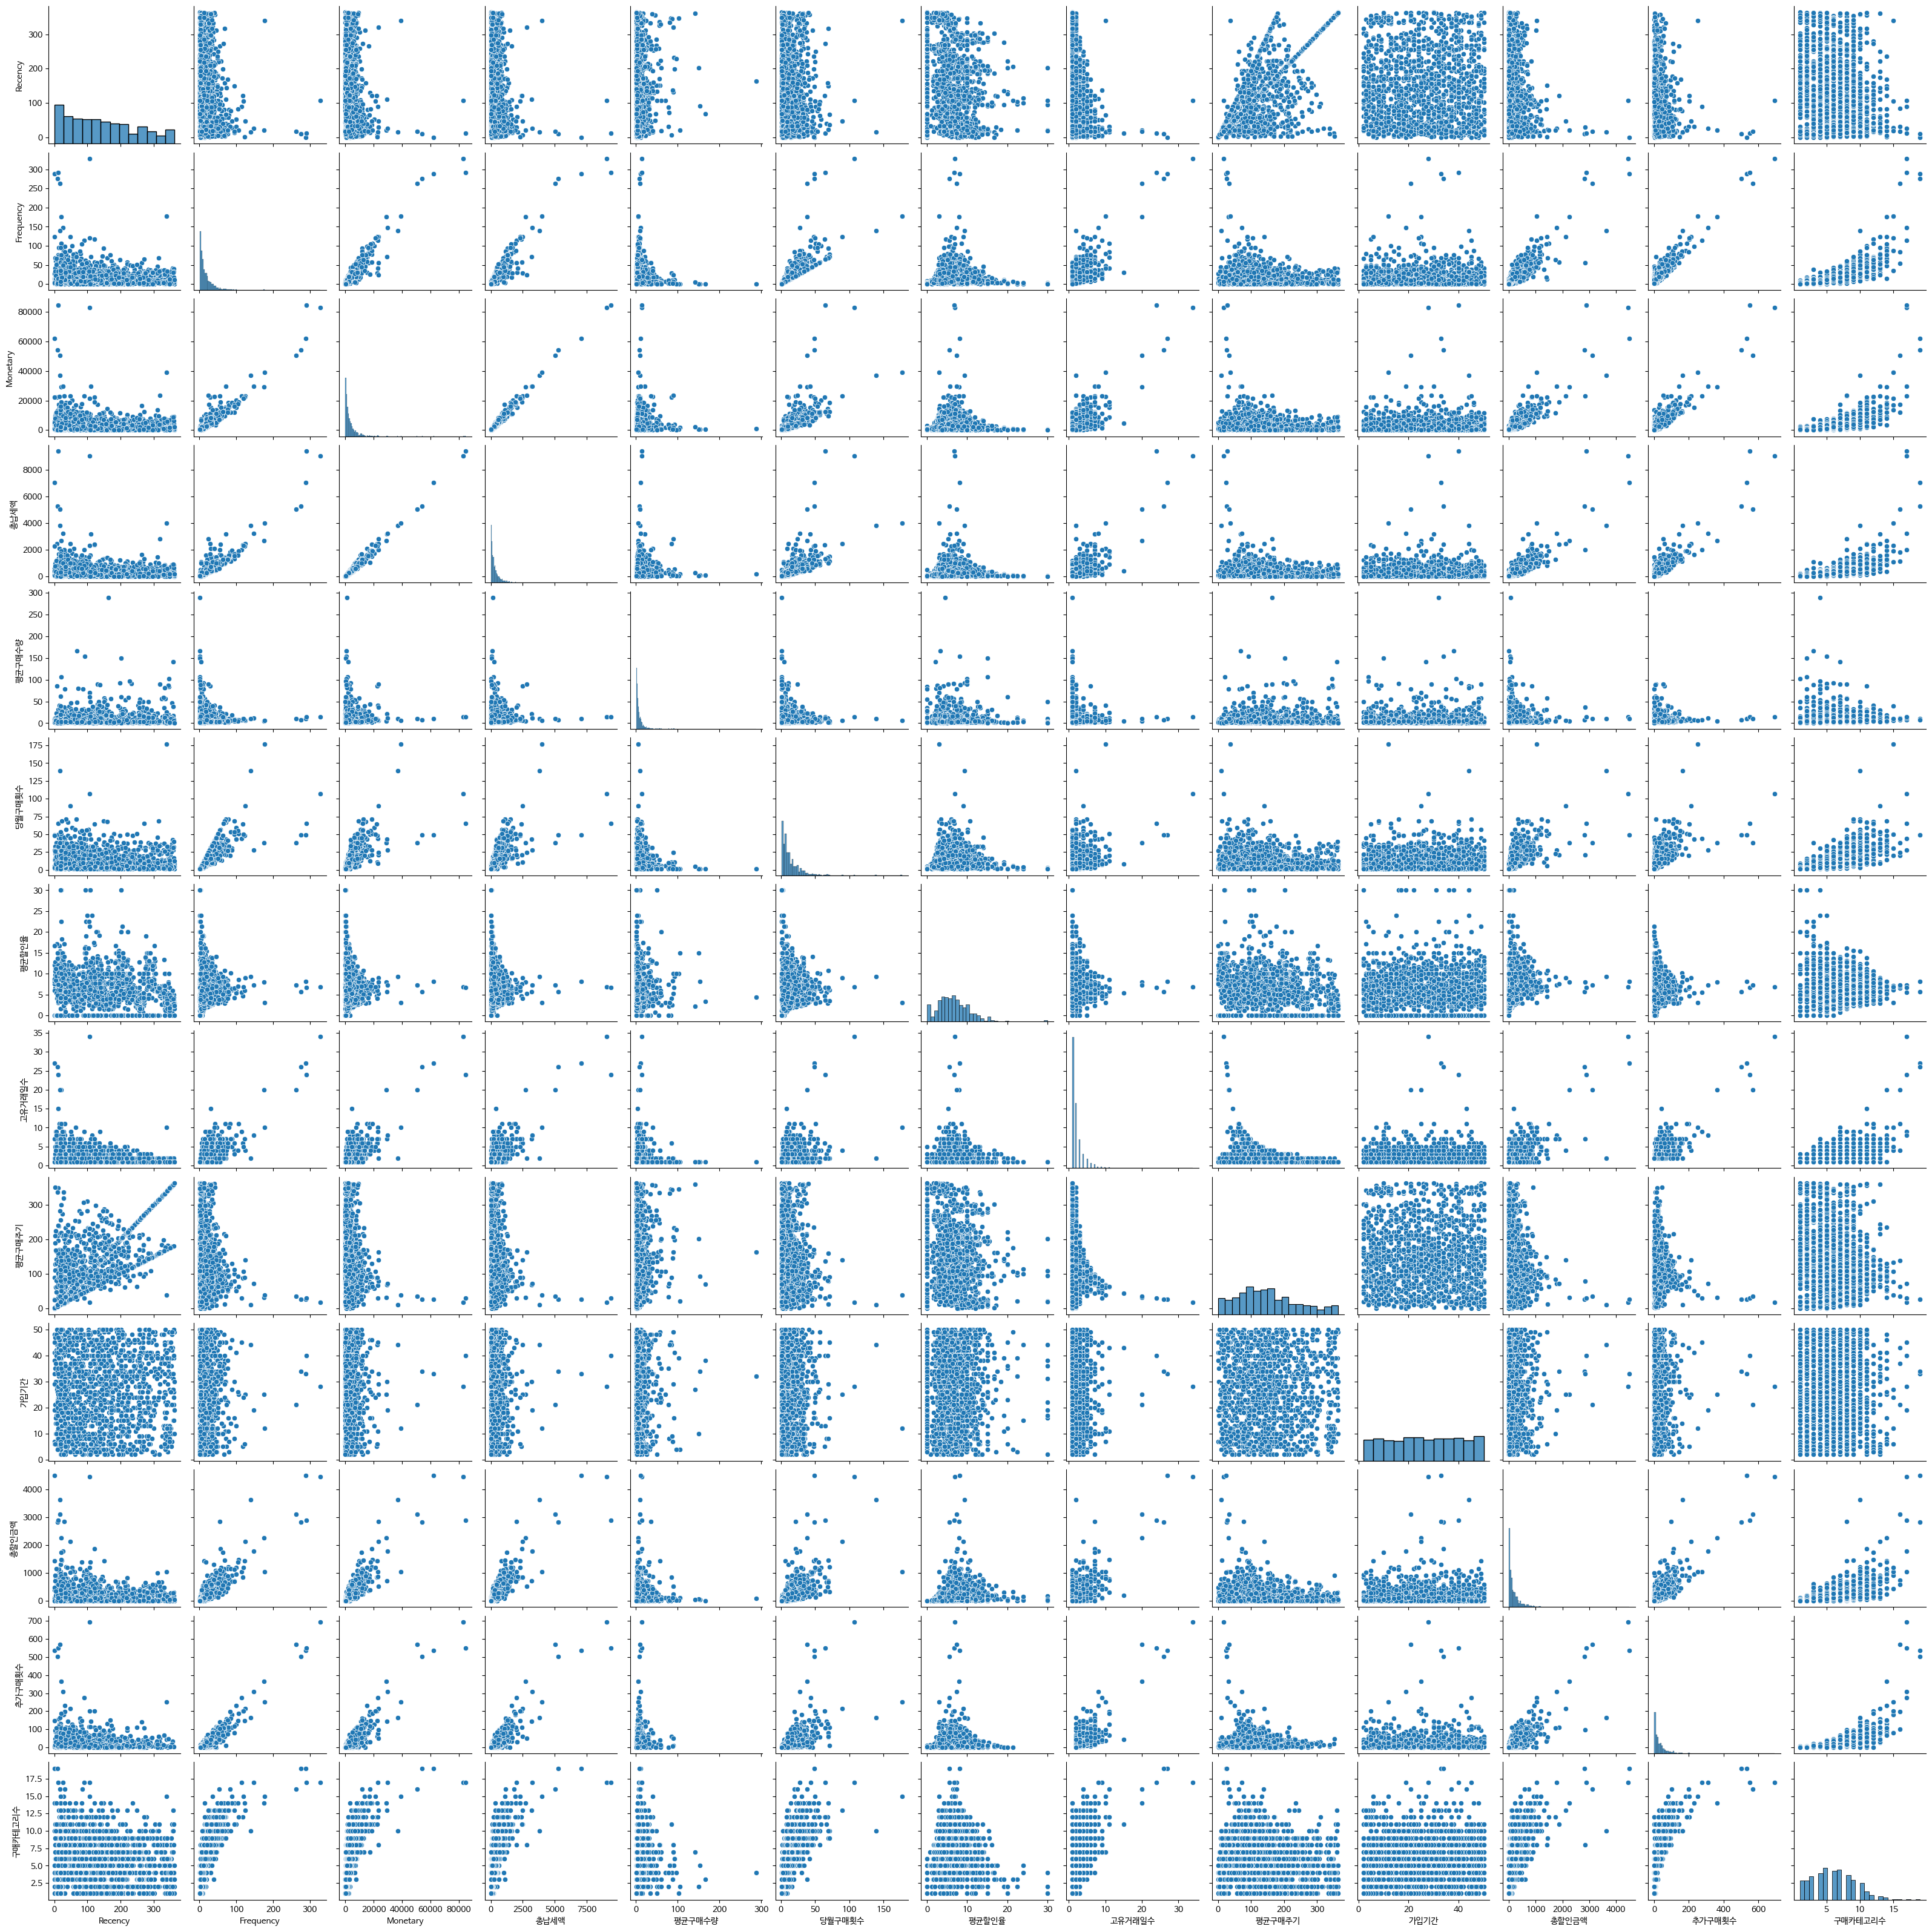

In [67]:
sns.pairplot(rfm[['Recency','Frequency','Monetary','총납세액','평균구매수량', '당월구매횟수','평균할인율','고유거래일수','평균구매주기', '가입기간', '총할인금액','추가구매횟수',	'구매카테고리수']])

In [ ]:
core = rfm[['Recency','Frequency','Monetary','총납세액','평균구매수량', '당월구매횟수','평균할인율','고유거래일수','평균구매주기', '가입기간', '총할인금액', 'Clicked_ratio','Used_ratio', 'Clicked_ratio_per_F','Used_ratio_per_F']].corr(method='pearson', min_periods=1)

In [ ]:
for i in core.index:
    display(pd.DataFrame(core.loc[i, :]))

In [47]:
label_r = [4, 3, 2, 1]
label_f = [1, 2, 3, 4]
label_m = [1, 2, 3, 4]

## EDA
## bins를 만들 때
## 각 컬럼의 히스토그램과 boxplot 등을 봤을 때
## 특정 구간에 밀도가 너무 높아서
## 그 구간을 다시 분할하여 bins 를 생성

# recency_score bins=[0, 70, 180, 280, 364]

rfm["recency_score"] = pd.cut(rfm["Recency"], bins=[0, 30, 90, 180, 364], labels=label_r, include_lowest=True)
rfm["frequency_score"] = pd.cut(rfm["Frequency"], bins=[0, 12, 25, 53, 329], labels=label_f, include_lowest=True)
rfm["monetary_score"] = pd.cut(rfm["Monetary"], bins=[0, 760, 1750, 7594, 90000], labels=label_m, include_lowest=True)
rfm["RFM_SCORE"] = rfm["recency_score"].astype(str) + rfm["frequency_score"].astype(str) + rfm["monetary_score"].astype(str)

In [48]:
seg_map = {
    r'[1-2]1[1-4]': 'Hibernating',          # 1
    r'[1-2]2[1-4]': 'About to Sleep',       # 2
    r'[1-2][3-4][1-4]': 'At Risk',          # 3
    r'3[1-2][1-4]': 'Can\'t Lose',          # 4
    r'3[3-4][1-4]': 'Typical',              # 5
    r'4[1-2][1-2]': 'New Customers',        # 6
    r'4[1-2][3-4]': 'Loyal Customers',      # 7
    r'4[3-4][1-3]': 'Loyal Customers',      # 7
    r'4[3-4][4]': 'VIP'                     # 8
}

rfm['Segmentation'] = rfm['RFM_SCORE'].replace(seg_map, regex=True)

In [49]:
indexing = ['VIP',
            'Loyal Customers',
            'Typical',
            'New Customers',
            'At Risk',
            'Can\'t Lose',
            'About to Sleep',
            'Hibernating'
            ]

In [50]:
seg_stats = pd.DataFrame((rfm['Segmentation'].value_counts()/ rfm['Segmentation'].count()).round(4)*100)

In [51]:
seg_stats.reindex(index=indexing)

count
Segmentation          
VIP               3.13
Loyal Customers   7.29
Typical           7.56
New Customers     5.65
At Risk          10.22
Can't Lose       13.62
About to Sleep   12.87
Hibernating      39.65

In [52]:
rfm.to_csv('user_feature.csv')

In [53]:
rfm.columns

Index(['고객ID', 'Recency', 'Frequency', 'Monetary', '총납세액', '평균구매수량', '최다구매월',
       '당월구매횟수', '평균할인율', '고유거래일수', '평균구매주기', 'First_category',
       'Second_category', 'Third_category', '성별', '고객지역', '가입기간', '총할인금액',
       'Used_ratio', 'Clicked_ratio', 'Used_ratio_per_F',
       'Clicked_ratio_per_F', '추가구매횟수', 'recency_score', 'frequency_score',
       'monetary_score', 'RFM_SCORE', 'Segmentation'],
      dtype='object')

In [54]:
def month_shift(x):
    dict = {1:'Jan',
            2:'Feb',
            3:'Mar',
            4:'Apr',
            5:'May',
            6:'Jun',
            7:'Jul',
            8:'Aug',
            9:'Sep',
            10:'Oct',
            11:'Nov',
            12:'Dec'}

    return dict[x]

In [55]:
df.columns

Index(['고객ID', '거래ID', '거래날짜', '제품ID', '제품카테고리', '수량', '평균금액', '배송료', '쿠폰상태',
       '성별', '고객지역', '가입기간', 'GST', '월', '쿠폰코드', '할인율', '오프라인비용', '온라인비용',
       'true_discount', '평균배송료', '납세액', '총금액', 'real_discount', 'df총할인금액'],
      dtype='object')

In [ ]:
df.groupby(['월', '제품카테고리'])['평균금액'].sum().unstack(fill_value=0).reindex(index=['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']).plot(kind='bar', stacked=True, figsize=[30, 20], fontsize=50)
plt.title('월별 최대매출 카테고리', fontsize=70)

In [ ]:
df.groupby(['월', '제품카테고리']).size().unstack(fill_value=0).reindex(index=['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']).plot(kind='bar', stacked=True, figsize=[30, 20], fontsize=50)
plt.title('월별 최다구매 카테고리', fontsize=70)


In [58]:
user_feature_core = pd.DataFrame(rfm.groupby('Segmentation')[['총납세액','평균구매수량' ,'평균할인율' ,'고유거래일수', '평균구매주기', '가입기간', '총할인금액']].mean().reindex(index=indexing))
user_feature_core

총납세액     평균구매수량     평균할인율    고유거래일수      평균구매주기  \
Segmentation                                                              
VIP              1858.580372  11.968926  7.390435  7.391304   99.086957   
Loyal Customers   365.628813   7.542917  8.523925  3.028037   85.280374   
Typical           836.782486   7.704747  6.164234  3.720721  100.972973   
New Customers      77.317601   4.547885  9.465301  1.734940   46.325301   
At Risk           846.500443   9.466860  6.613467  2.993333  147.426667   
Can't Lose        207.854217   9.688639  5.224400  1.950000   92.315000   
About to Sleep    347.562559   9.613261  6.735450  1.915344  174.317460   
Hibernating        96.884352  10.867668  6.681856  1.350515  202.960481   

                      가입기간        총할인금액  
Segmentation                             
VIP              25.565217  1221.132500  
Loyal Customers  25.794393   292.576561  
Typical          25.864865   500.181252  
New Customers    27.638554    71.881795  
At Risk          24.980000   465.457153  
Can't Lose       24.960000   114.359050  
About to Sleep   27.253968   198.647296  
Hibernating      25.855670    54.250242

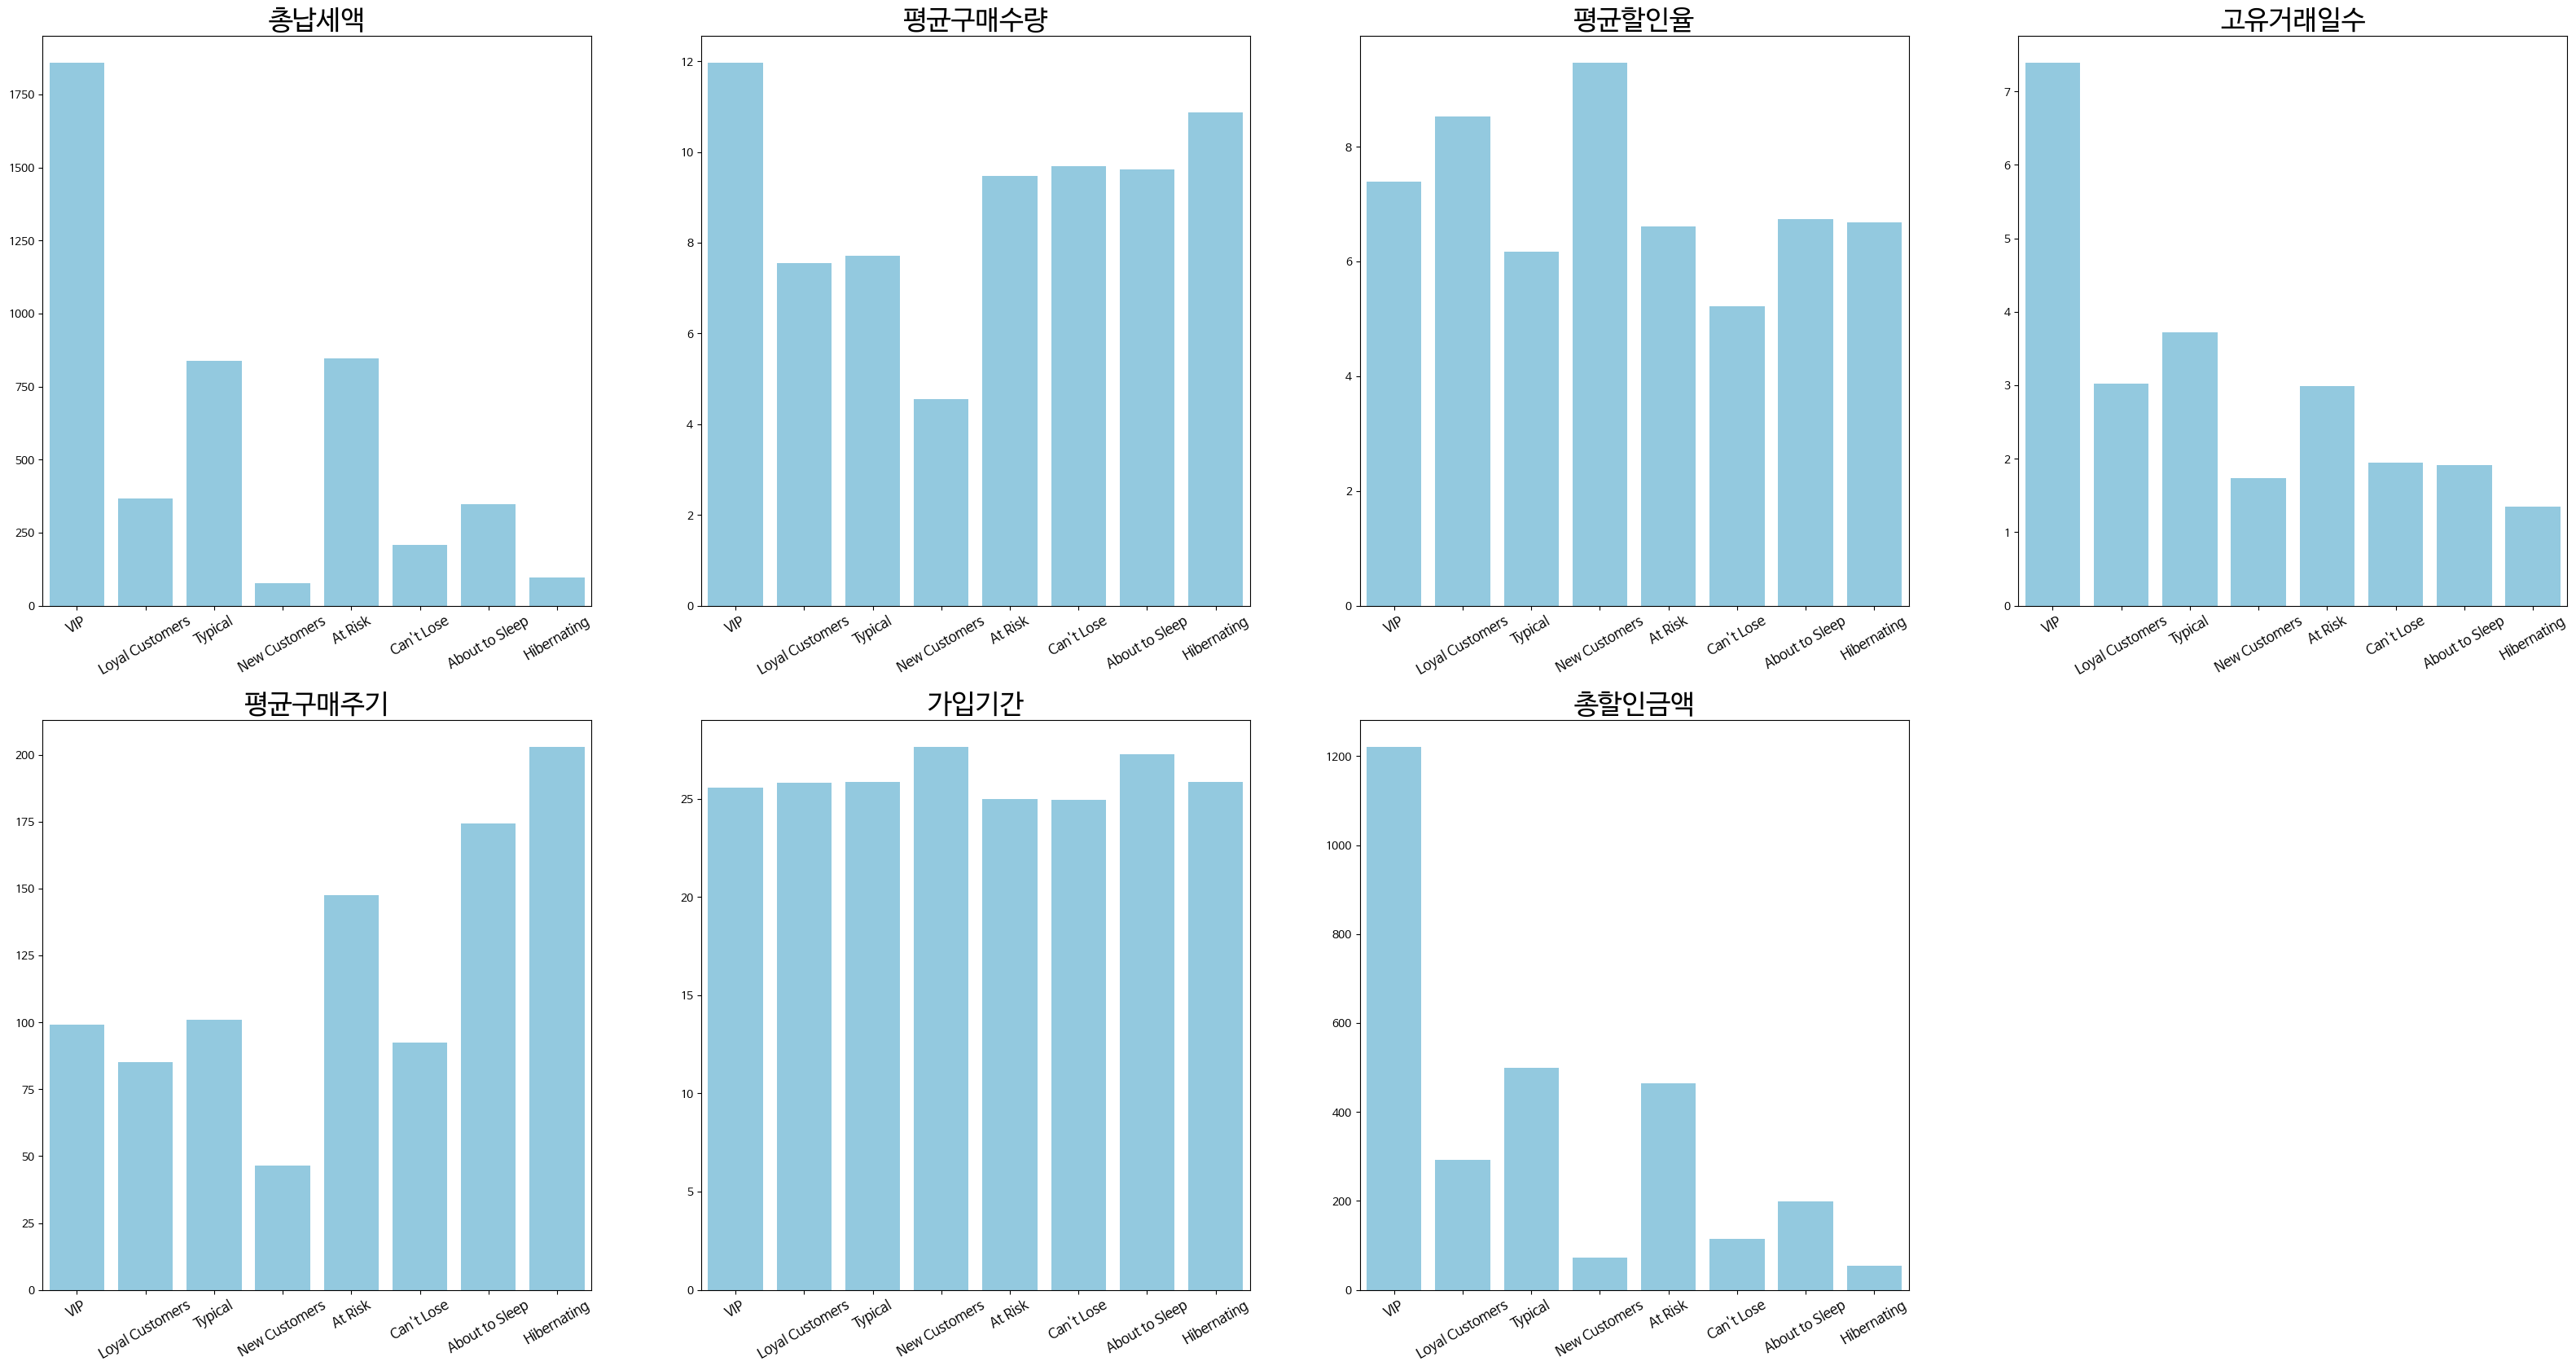

In [59]:
plt.figure(figsize=(40, 20))
for i, col in enumerate(user_feature_core.columns):
    plt.subplot(2, 4, i+1)
    sns.barplot(data=user_feature_core, x=user_feature_core.index, y=col, color='skyblue')
    plt.title(col, fontsize=24)
    plt.xticks(rotation=30, fontsize=12)
    plt.ylabel("")
    plt.xlabel("")

plt.show()

## 클러스터링

### 1. k-means, pca

In [60]:
rfm.columns

Index(['고객ID', 'Recency', 'Frequency', 'Monetary', '총납세액', '평균구매수량', '최다구매월',
       '당월구매횟수', '평균할인율', '고유거래일수', '평균구매주기', 'First_category',
       'Second_category', 'Third_category', '성별', '고객지역', '가입기간', '총할인금액',
       'Used_ratio', 'Clicked_ratio', 'Used_ratio_per_F',
       'Clicked_ratio_per_F', '추가구매횟수', 'recency_score', 'frequency_score',
       'monetary_score', 'RFM_SCORE', 'Segmentation'],
      dtype='object')

In [61]:
rfm

고객ID  Recency  Frequency    Monetary       총납세액     평균구매수량 최다구매월  \
0     USER_0000      107          1    101.3912     4.6982   3.000000   Sep   
1     USER_0001       59         31  15407.7190  2067.9070  11.032258   Nov   
2     USER_0002       73          8   1596.0858   203.6008  26.125000   Jun   
3     USER_0003       17         11   1438.5072   148.2642   1.909091   Dec   
4     USER_0004      107         13   1541.9718   151.7598   4.307692   Sep   
...         ...      ...        ...         ...        ...        ...   ...   
1463  USER_1463      270          3    678.7202    51.2202  15.333333   Apr   
1464  USER_1464       87         19   2631.9586   277.1706   7.421053   Aug   
1465  USER_1465      194          2    128.5234    18.0264   5.000000   Apr   
1466  USER_1466       69          1    333.8000    29.8000   2.000000   Oct   
1467  USER_1467       82         53   7000.0783   583.1923   2.924528   Oct   

      당월구매횟수  평균할인율  고유거래일수  평균구매주기 First_category       Second_category  \
0          1  30.00       1     107        Apparel                Office   
1         18   8.00       3     168       Nest-USA               Apparel   
2          4  11.74       2     155         Office             Lifestyle   
3         11  10.59       1      17        Apparel              Nest-USA   
4         13   9.17       1     107        Apparel                Office   
...      ...    ...     ...     ...            ...                   ...   
1463       3   4.29       1     270        Apparel  Notebooks & Journals   
1464      10   9.25       3      99        Apparel              Nest-USA   
1465       1   3.75       2     173        Apparel                Office   
1466       1   0.00       1      69       Nest-USA                  None   
1467      31   3.73       2     114        Apparel              Nest-USA   

     Third_category 성별        고객지역  가입기간    총할인금액  Used_ratio  Clicked_ratio  \
0              None  여    New York    31    9.297    0.000000       1.000000   
1            Office  남    New York    20  781.548    0.433333       0.333333   
2           Apparel  남  California    39  130.705    0.478261       0.478261   
3       Nest-Canada  남  California    25  152.217    0.470588       0.352941   
4          Nest-USA  여     Chicago    31  206.748    0.472222       0.305556   
...             ... ..         ...   ...      ...         ...            ...   
1463      More Bags  여  California     5   11.190    0.428571       0.428571   
1464         Office  남    New York    43  230.312    0.525000       0.400000   
1465           None  남     Chicago    25    3.563    0.500000       0.375000   
1466           None  여     Chicago    47    0.000    0.000000       0.000000   
1467         Office  여  New Jersey    36  283.754    0.500000       0.372549   

      Used_ratio_per_F  Clicked_ratio_per_F  추가구매횟수 recency_score  \
0             0.000000             1.000000     NaN             2   
1             0.013978             0.010753    29.0             3   
2             0.059783             0.059783     6.0             3   
3             0.042781             0.032086     NaN             4   
4             0.036325             0.023504     NaN             2   
...                ...                  ...     ...           ...   
1463          0.142857             0.142857     NaN             1   
1464          0.027632             0.021053    29.0             3   
1465          0.250000             0.187500     1.0             1   
1466          0.000000             0.000000     NaN             3   
1467          0.009434             0.007029    45.0             3   

     frequency_score monetary_score RFM_SCORE    Segmentation  
0                  1              1       211     Hibernating  
1                  3              4       334         Typical  
2                  1              2       312      Can't Lose  
3                  1              2       412   New Customers  
4                  2              2    

In [62]:
rfm_category = rfm[['최다구매월', 'First_category',	'Second_category',	'Third_category', '성별', '고객지역']]
rfm_numeric = rfm[['Recency', 'Frequency','Monetary', 'recency_score', 'frequency_score', 'monetary_score', '총납세액', '평균구매수량', '평균할인율', '고유거래일수', '평균구매주기', '가입기간', '총할인금액', 'Clicked_ratio', 'Used_ratio']]
rfm_label = rfm['고객ID']


In [63]:
# log 스캐일링 -

# for col in rfm_numeric.columns:
#     plt.hist(rfm_numeric[col])
#     plt.title(col)
#     plt.show()

In [64]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

# rfm_numeric_log = rfm_numeric[['Frequency', 'Monetary', '총납세액', '평균구매수량', '평균할인율', '고유거래일수', '총할인금액']]
# rfm_numeric_s = rfm_numeric.drop(['Frequency', 'Monetary', '총납세액', '평균구매수량', '평균할인율', '고유거래일수', '총할인금액'], axis=1)

In [65]:
# rfm_numeric_log = np.log1p(rfm_numeric_log)

In [66]:
rfm_numeric = pd.DataFrame(data=scaler.fit_transform(rfm_numeric), columns=rfm_numeric.columns)

In [67]:
# rfm_numeric_done = pd.concat([rfm_numeric_log, rfm_numeric_s], axis=1)


In [68]:
def category_merge(x):
    if x in ['Nest', 'Nest-USA', 'Nest-Canada']:
        return 'Nest'
    elif x in ['Apparel', 'Bags', 'Accessories', 'Headgear', 'More Bags', 'Headgear', 'Backpacks']:
        return 'Apparel'
    elif x in ['Lifestyle', 'Fun', 'Gift Cards']:
        return 'Lifestyle'
    elif x in ['Waze', 'Google', 'Android']:
        return 'IT'
    elif x in ['Housewares', 'Drinkware', 'Bottles']:
        return 'Housewares'
    elif x in ['Office', 'Notebooks & Journals']:
        return 'Stationery'
    else:
        return 'None'

In [69]:
rfm_category['First_category'] = rfm_category['First_category'].apply(category_merge)
rfm_category['Second_category'] = rfm_category['Second_category'].apply(category_merge)
rfm_category['Third_category'] = rfm_category['Third_category'].apply(category_merge)

rfm_category_core = rfm_category[['First_category', '성별']]

In [70]:
rfm_dummies = pd.get_dummies(rfm_category_core).astype(int)
rfm_dummies

First_category_Apparel  First_category_Housewares  First_category_IT  \
0                          1                          0                  0   
1                          0                          0                  0   
2                          0                          0                  0   
3                          1                          0                  0   
4                          1                          0                  0   
...                      ...                        ...                ...   
1463                       1                          0                  0   
1464                       1                          0                  0   
1465                       1                          0                  0   
1466                       0                          0                  0   
1467                       1                          0                  0   

      First_category_Lifestyle  First_category_Nest  \
0                            0                    0   
1                            0                    1   
2                            0                    0   
3                            0                    0   
4                            0                    0   
...                        ...                  ...   
1463                         0                    0   
1464                         0                    0   
1465                         0                    0   
1466                         0                    1   
1467                         0                    0   

      First_category_Stationery  성별_남  성별_여  
0                             0     0     1  
1                             0     1     0  
2                             1     1     0  
3                             0     1     0  
4                             0     0     1  
...                         ...   ...   ...  
1463                          0     0     1  
1464                          0     1     0  
1465                          0     1     0  
1466                          0     0     1  
1467                          0     0     1  

[1468 rows x 8 columns]

In [71]:
rfm_after_preprocessing = pd.concat([rfm_label, rfm_numeric[['Recency', 'Frequency', 'Monetary', 'Used_ratio']], rfm_dummies], axis=1)
rfm_after_preprocessing

고객ID   Recency  Frequency  Monetary  Used_ratio  \
0     USER_0000 -0.365961  -0.686522 -0.609127   -2.997581   
1     USER_0001 -0.837001   0.515021  2.147713   -0.444827   
2     USER_0002 -0.699614  -0.406162 -0.339916   -0.180160   
3     USER_0003 -1.249160  -0.286007 -0.368298   -0.225359   
4     USER_0004 -0.365961  -0.205905 -0.349663   -0.215733   
...         ...       ...        ...       ...         ...   
1463  USER_1463  1.233611  -0.606419 -0.505144   -0.472879   
1464  USER_1464 -0.562227   0.034404 -0.153344    0.095179   
1465  USER_1465  0.487799  -0.646470 -0.604241   -0.052095   
1466  USER_1466 -0.738867  -0.686522 -0.567268   -2.997581   
1467  USER_1467 -0.611294   1.396152  0.633403   -0.052095   

      First_category_Apparel  First_category_Housewares  First_category_IT  \
0                          1                          0                  0   
1                          0                          0                  0   
2                          0                          0                  0   
3                          1                          0                  0   
4                          1                          0                  0   
...                      ...                        ...                ...   
1463                       1                          0                  0   
1464                       1                          0                  0   
1465                       1                          0                  0   
1466                       0                          0                  0   
1467                       1                          0                  0   

      First_category_Lifestyle  First_category_Nest  \
0                            0                    0   
1                            0                    1   
2                            0                    0   
3                            0                    0   
4                            0                    0   
...                        ...                  ...   
1463                         0                    0   
1464                         0                    0   
1465                         0                    0   
1466                         0                    1   
1467                         0                    0   

      First_category_Stationery  성별_남  성별_여  
0                             0     0     1  
1                             0     1     0  
2                             1     1     0  
3                             0     1     0  
4                             0     0     1  
...                         ...   ...   ...  
1463                          0     0     1  
1464                          0     1     0  
1465                          0     1     0  
1466                          0     0     1  
1467                          0     0     1  

[1468 rows x 13 columns]

In [72]:
rfm_core = rfm_after_preprocessing.iloc[:, 1:4]
rfm_core


Recency  Frequency  Monetary
0    -0.365961  -0.686522 -0.609127
1    -0.837001   0.515021  2.147713
2    -0.699614  -0.406162 -0.339916
3    -1.249160  -0.286007 -0.368298
4    -0.365961  -0.205905 -0.349663
...        ...        ...       ...
1463  1.233611  -0.606419 -0.505144
1464 -0.562227   0.034404 -0.153344
1465  0.487799  -0.646470 -0.604241
1466 -0.738867  -0.686522 -0.567268
1467 -0.611294   1.396152  0.633403

[1468 rows x 3 columns]

In [73]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

from datetime import datetime, timedelta
from dateutil.relativedelta import relativedelta

from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import AgglomerativeClustering, KMeans, DBSCAN
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler

## 1. 덴드로그램

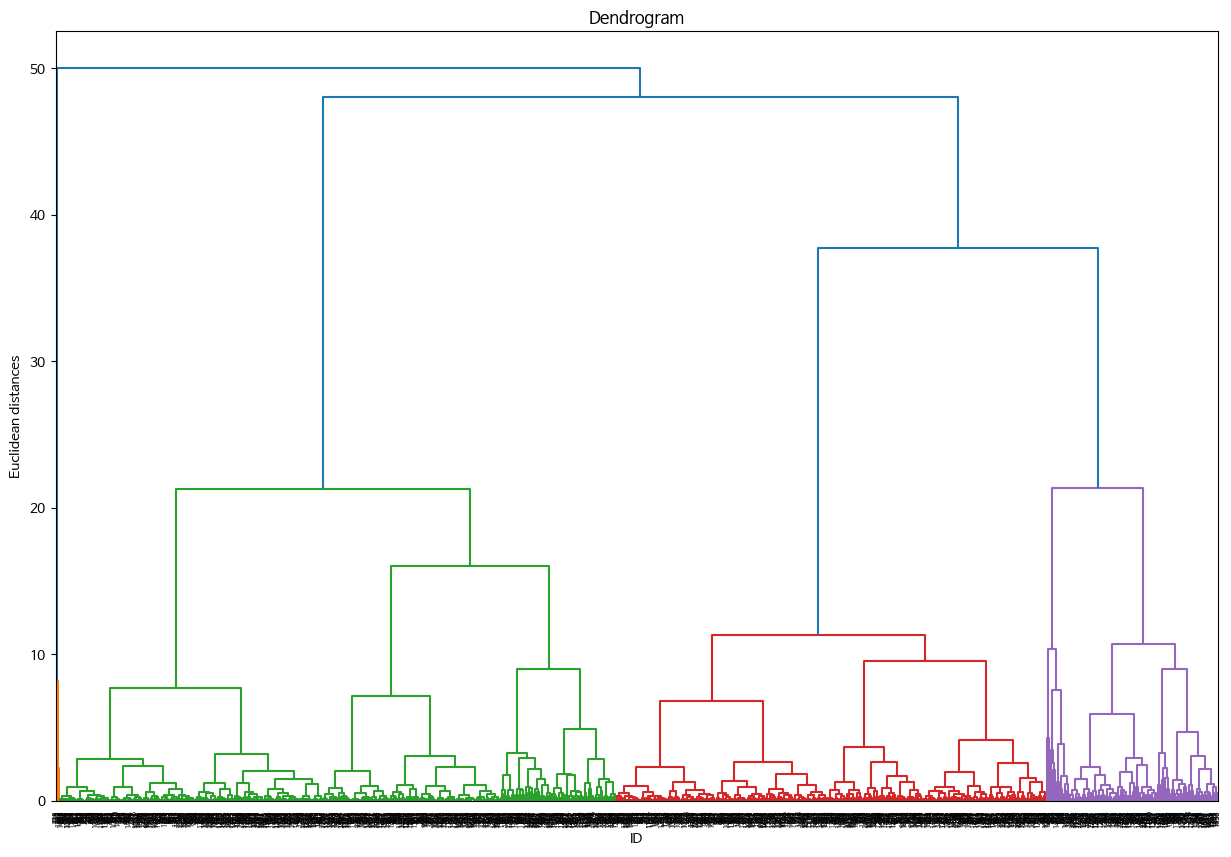

In [74]:
plt.figure(figsize=(15,10))
plt.title('Dendrogram')
plt.xlabel('ID')
plt.ylabel('Euclidean distances')
dgram = dendrogram(linkage(rfm_core, method = 'ward'))
plt.show()

## 2. kmeans

In [75]:
for k in range(2, 9):
    kmeans = KMeans(n_clusters=k, random_state=9, init='k-means++').fit(rfm_core)
    silhouette_avg = silhouette_score(rfm_core, kmeans.labels_)
    print("k = {} -> silhouette index {}".format(k, silhouette_avg))

k = 2 -> silhouette index 0.6008341860238484
k = 3 -> silhouette index 0.39990631894155715
k = 4 -> silhouette index 0.446014630730219
k = 5 -> silhouette index 0.4233643436745365
k = 6 -> silhouette index 0.3945319100901026
k = 7 -> silhouette index 0.4036346272672706
k = 8 -> silhouette index 0.4012911588652544


In [76]:
for k in range(2, 9):
    kmeans = KMeans(n_clusters=k, random_state=9, init='random').fit(rfm_core)
    silhouette_avg = silhouette_score(rfm_core, kmeans.labels_)
    print("k = {} -> silhouette index {}".format(k, silhouette_avg))

k = 2 -> silhouette index 0.5656542674172487
k = 3 -> silhouette index 0.4033984697308608
k = 4 -> silhouette index 0.4459034130186614
k = 5 -> silhouette index 0.3840714079413141
k = 6 -> silhouette index 0.3954155989179939
k = 7 -> silhouette index 0.3784631795623791
k = 8 -> silhouette index 0.3625866427100215


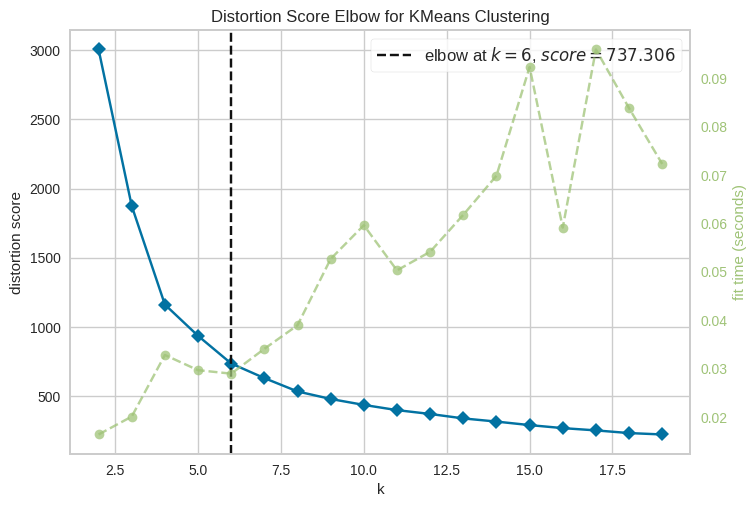

KElbowVisualizer(ax=<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>,
                 estimator=KMeans(n_clusters=19, random_state=9), k=(2, 20))

In [77]:
from yellowbrick.cluster.elbow import kelbow_visualizer

kelbow_visualizer(KMeans(random_state=9), rfm_core, k=(2,20))


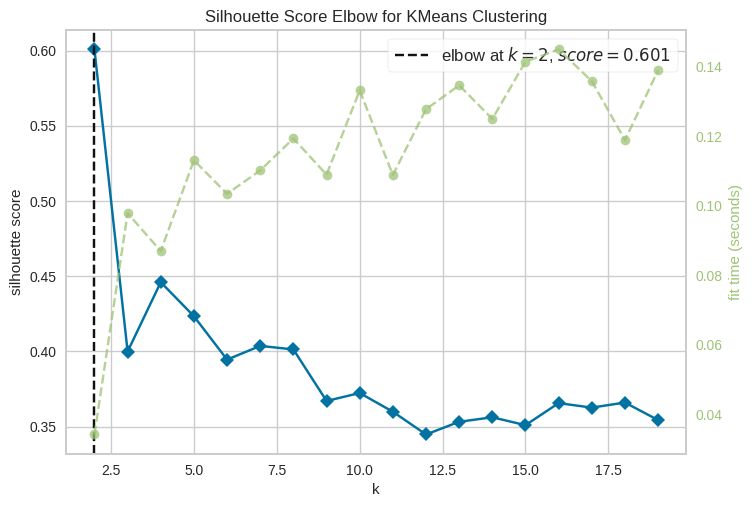

KElbowVisualizer(ax=<Axes: title={'center': 'Silhouette Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='silhouette score'>,
                 estimator=KMeans(n_clusters=19, random_state=9), k=(2, 20),
                 metric='silhouette')

In [78]:
kelbow_visualizer(KMeans(random_state=9), rfm_core, k=(2,20), metric="silhouette")

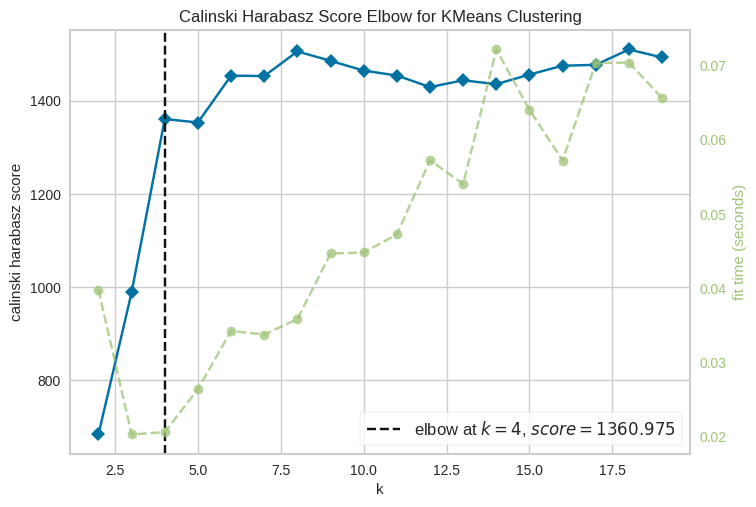

KElbowVisualizer(ax=<Axes: title={'center': 'Calinski Harabasz Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='calinski harabasz score'>,
                 estimator=KMeans(n_clusters=19, random_state=9), k=(2, 20),
                 metric='calinski_harabasz')

In [79]:
kelbow_visualizer(KMeans(random_state=9), rfm_core, k=(2,20), metric="calinski_harabasz")


## 3. pca + kmeans

In [80]:
pca_2 = PCA(n_components = 2)

rfm_pca2 = pd.DataFrame(data=pca_2.fit_transform(rfm_core), columns=['pca1', 'pca2'])
rfm_pca2

pca1      pca2
0    -0.778710 -0.605154
1     2.039470 -0.268201
2    -0.312769 -0.817938
3    -0.097777 -1.329076
4    -0.275718 -0.461754
...        ...       ...
1463 -1.097547  0.967805
1464  0.075407 -0.564988
1465 -0.985057  0.223546
1466 -0.646838 -0.954832
1467  1.549166 -0.195277

[1468 rows x 2 columns]

Text(0, 0.5, 'Monetary')

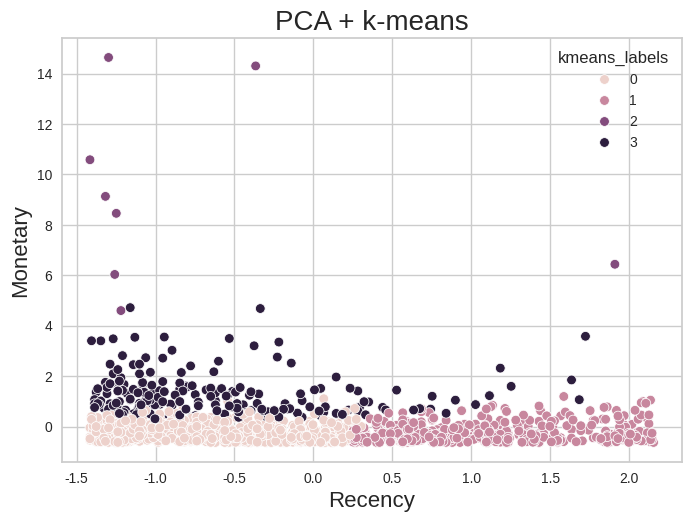

In [81]:
kmeans = KMeans(n_clusters=4, random_state=9, init='random').fit(rfm_pca2)

rfm_core['kmeans_labels'] = kmeans.labels_


sns.scatterplot(data = rfm_core, x='Recency', y='Monetary', hue='kmeans_labels')
plt.title('PCA + k-means', fontsize=20)
plt.xlabel('Recency', fontsize=16)
plt.ylabel('Monetary', fontsize=16)


In [82]:
for k in range(3, 9):
    kmeans = KMeans(n_clusters=k, random_state=9, init='k-means++').fit(rfm_pca2)
    silhouette_avg = silhouette_score(rfm_pca2, kmeans.labels_)
    print("k = {} -> silhouette index {}".format(k, silhouette_avg))

k = 3 -> silhouette index 0.4073913660674769
k = 4 -> silhouette index 0.4557619205250221
k = 5 -> silhouette index 0.4293735913791475
k = 6 -> silhouette index 0.4086500515303324
k = 7 -> silhouette index 0.4190972132577281
k = 8 -> silhouette index 0.4181823092942683


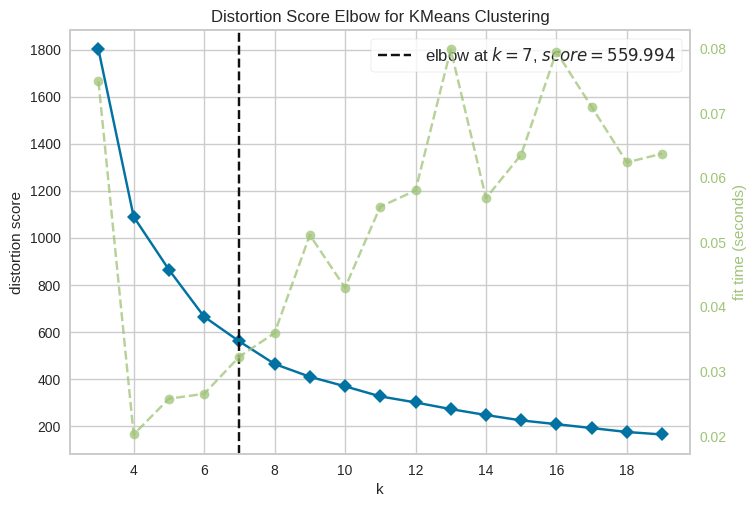

KElbowVisualizer(ax=<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>,
                 estimator=KMeans(n_clusters=19, random_state=9), k=(3, 20))

In [83]:
kelbow_visualizer(KMeans(random_state=9), rfm_pca2, k=(3,20))

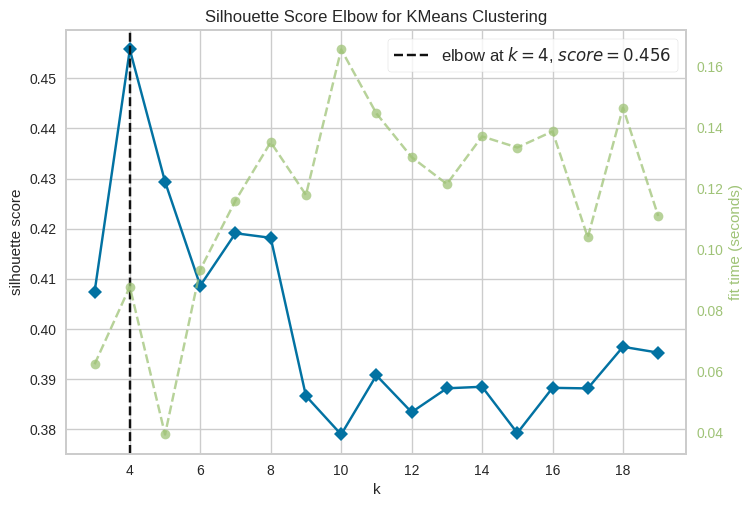

KElbowVisualizer(ax=<Axes: title={'center': 'Silhouette Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='silhouette score'>,
                 estimator=KMeans(n_clusters=19, random_state=9), k=(3, 20),
                 metric='silhouette')

In [84]:
kelbow_visualizer(KMeans(random_state=9), rfm_pca2, k=(3,20), metric='silhouette')

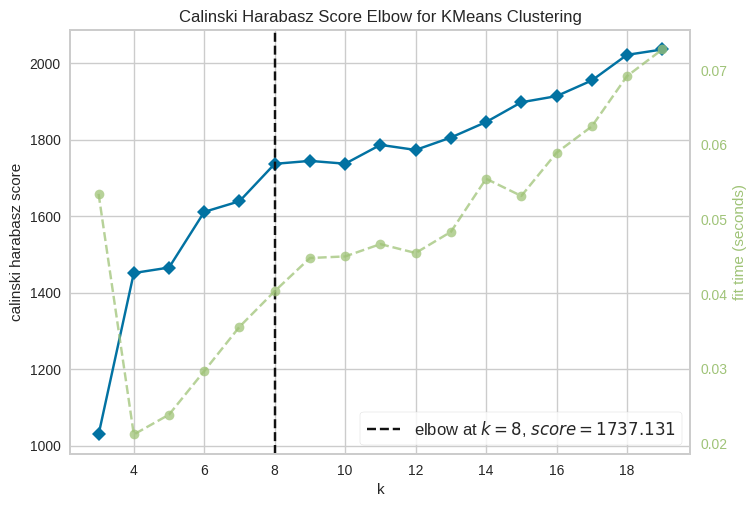

KElbowVisualizer(ax=<Axes: title={'center': 'Calinski Harabasz Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='calinski harabasz score'>,
                 estimator=KMeans(n_clusters=19, random_state=9), k=(3, 20),
                 metric='calinski_harabasz')

In [85]:
kelbow_visualizer(KMeans(random_state=9), rfm_pca2, k=(3,20), metric="calinski_harabasz")

In [86]:
for k in range(3, 9):
    kmeans = KMeans(n_clusters=k, random_state=9, init='random').fit(rfm_pca2)
    silhouette_avg = silhouette_score(rfm_pca2, kmeans.labels_)
    print("k = {} -> silhouette index {}".format(k, silhouette_avg))

k = 3 -> silhouette index 0.4112680187271258
k = 4 -> silhouette index 0.45585625001287067
k = 5 -> silhouette index 0.39715751848631425
k = 6 -> silhouette index 0.40975586217574744
k = 7 -> silhouette index 0.4194597865853604
k = 8 -> silhouette index 0.37860325944835077


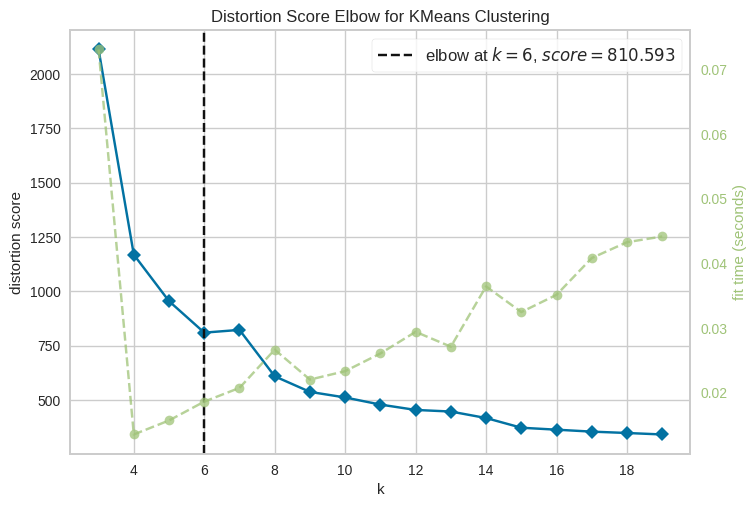

KElbowVisualizer(ax=<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>,
                 estimator=KMeans(init='random', n_clusters=19,
                                  random_state=42),
                 k=(3, 20))

In [87]:
kelbow_visualizer(KMeans(random_state=42, init='random'), rfm_core, k=(3,20))

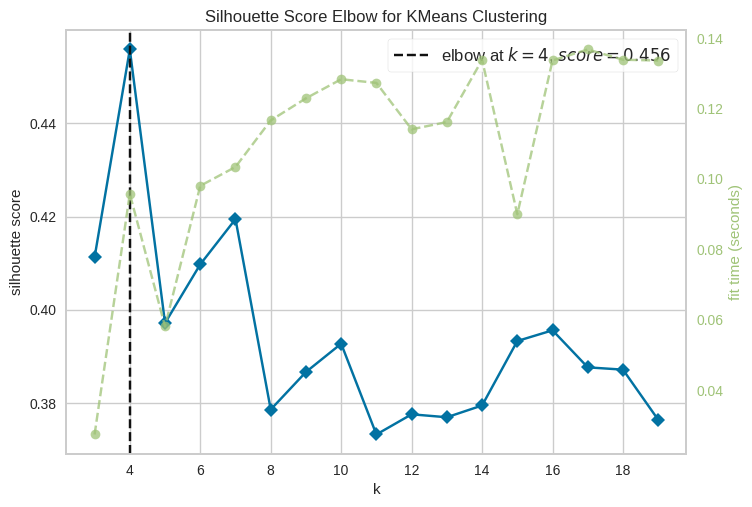

KElbowVisualizer(ax=<Axes: title={'center': 'Silhouette Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='silhouette score'>,
                 estimator=KMeans(init='random', n_clusters=19, random_state=9),
                 k=(3, 20), metric='silhouette')

In [88]:
kelbow_visualizer(KMeans(random_state=9, init='random'), rfm_pca2, k=(3,20), metric="silhouette")

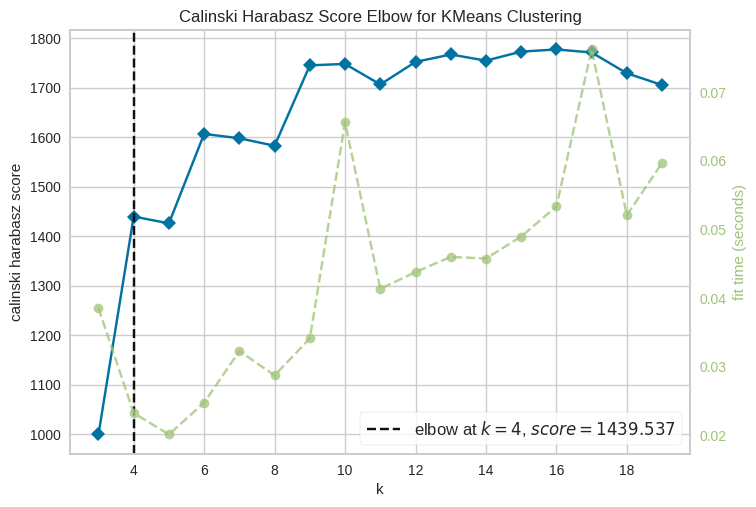

KElbowVisualizer(ax=<Axes: title={'center': 'Calinski Harabasz Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='calinski harabasz score'>,
                 estimator=KMeans(init='random', n_clusters=19, random_state=9),
                 k=(3, 20), metric='calinski_harabasz')

In [89]:
kelbow_visualizer(KMeans(random_state=9, init='random'), rfm_pca2, k=(3,20), metric="calinski_harabasz")

In [90]:
from sklearn.cluster import DBSCAN

In [91]:
rfm_core

Recency  Frequency  Monetary  kmeans_labels
0    -0.365961  -0.686522 -0.609127              0
1    -0.837001   0.515021  2.147713              3
2    -0.699614  -0.406162 -0.339916              0
3    -1.249160  -0.286007 -0.368298              0
4    -0.365961  -0.205905 -0.349663              0
...        ...        ...       ...            ...
1463  1.233611  -0.606419 -0.505144              1
1464 -0.562227   0.034404 -0.153344              0
1465  0.487799  -0.646470 -0.604241              1
1466 -0.738867  -0.686522 -0.567268              0
1467 -0.611294   1.396152  0.633403              3

[1468 rows x 4 columns]

In [92]:
rfm_core

Recency  Frequency  Monetary  kmeans_labels
0    -0.365961  -0.686522 -0.609127              0
1    -0.837001   0.515021  2.147713              3
2    -0.699614  -0.406162 -0.339916              0
3    -1.249160  -0.286007 -0.368298              0
4    -0.365961  -0.205905 -0.349663              0
...        ...        ...       ...            ...
1463  1.233611  -0.606419 -0.505144              1
1464 -0.562227   0.034404 -0.153344              0
1465  0.487799  -0.646470 -0.604241              1
1466 -0.738867  -0.686522 -0.567268              0
1467 -0.611294   1.396152  0.633403              3

[1468 rows x 4 columns]

Text(0, 0.5, 'Monetary')

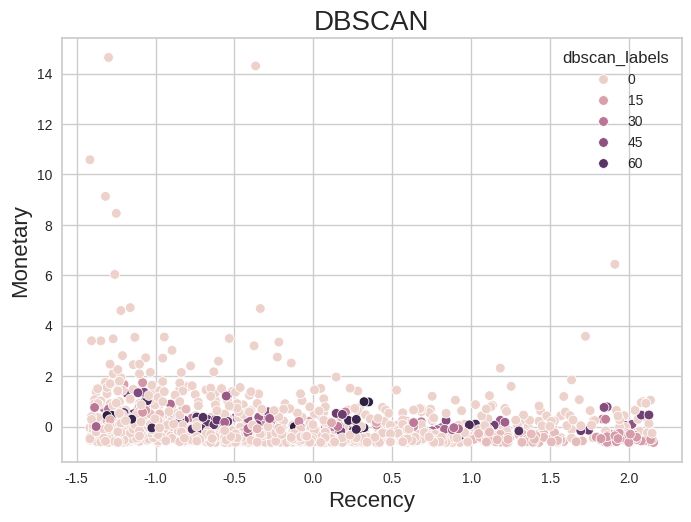

In [93]:
dbscan = DBSCAN(eps=0.1, min_samples=2).fit(rfm_core.iloc[:, :3])


rfm_core['dbscan_labels'] = dbscan.labels_


sns.scatterplot(data = rfm_core, x='Recency', y='Monetary', hue='dbscan_labels')
plt.title('DBSCAN', fontsize=20)
plt.xlabel('Recency', fontsize=16)
plt.ylabel('Monetary', fontsize=16)

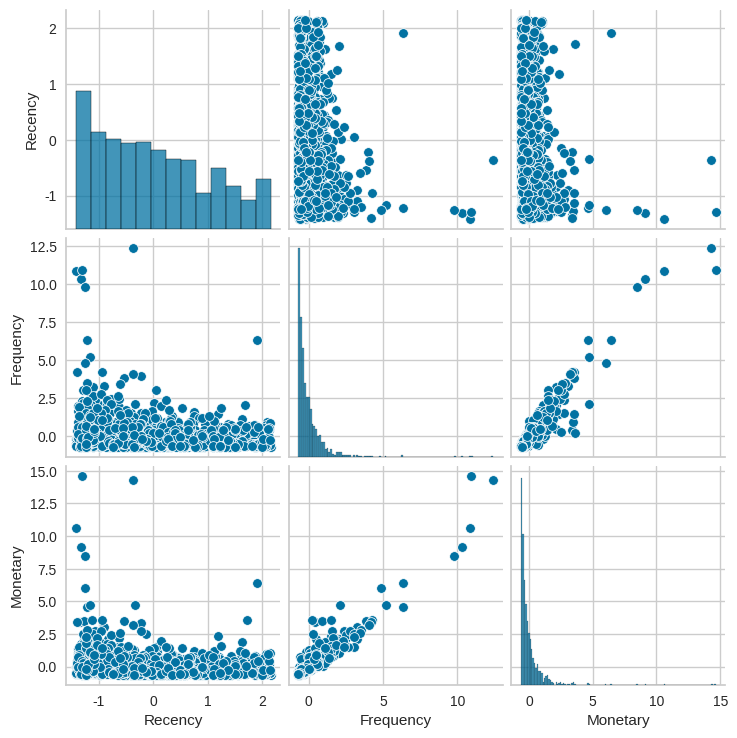

In [94]:
sns.pairplot(rfm_core[['Recency','Frequency','Monetary']])

In [95]:
rfm_core

Recency  Frequency  Monetary  kmeans_labels  dbscan_labels
0    -0.365961  -0.686522 -0.609127              0              0
1    -0.837001   0.515021  2.147713              3             -1
2    -0.699614  -0.406162 -0.339916              0              0
3    -1.249160  -0.286007 -0.368298              0              0
4    -0.365961  -0.205905 -0.349663              0              0
...        ...        ...       ...            ...            ...
1463  1.233611  -0.606419 -0.505144              1              6
1464 -0.562227   0.034404 -0.153344              0              0
1465  0.487799  -0.646470 -0.604241              1              0
1466 -0.738867  -0.686522 -0.567268              0              0
1467 -0.611294   1.396152  0.633403              3             -1

[1468 rows x 5 columns]

In [96]:
for k in range(3, 9):
    h_cluster = rfm_clustering = AgglomerativeClustering(n_clusters = k, metric = 'euclidean', linkage = 'ward').fit_predict(rfm_core)
    silhouette_avg = silhouette_score(rfm_core, h_cluster)
    print("k = {} -> silhouette index {}".format(k, silhouette_avg))

k = 3 -> silhouette index 0.8002194737788108
k = 4 -> silhouette index 0.7601438536709526
k = 5 -> silhouette index 0.6836476492237815
k = 6 -> silhouette index 0.6787901041412018
k = 7 -> silhouette index 0.6461699951756228
k = 8 -> silhouette index 0.6472283378959378


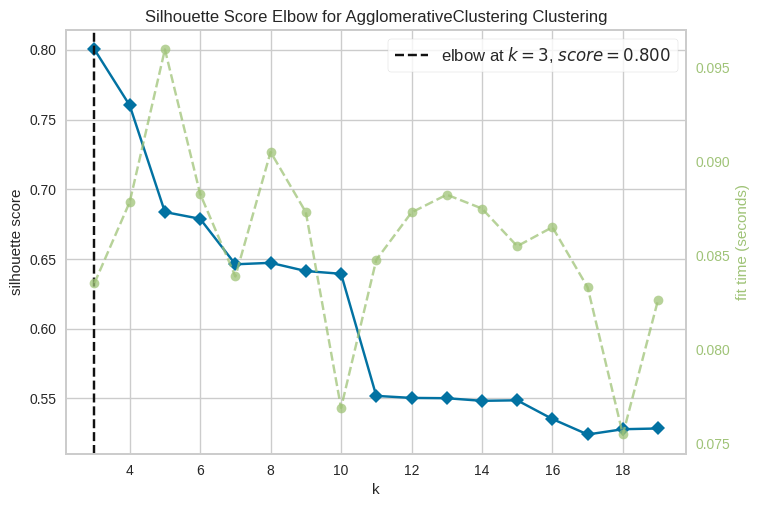

KElbowVisualizer(ax=<Axes: title={'center': 'Silhouette Score Elbow for AgglomerativeClustering Clustering'}, xlabel='k', ylabel='silhouette score'>,
                 estimator=AgglomerativeClustering(metric='euclidean',
                                                   n_clusters=19),
                 k=(3, 20), metric='silhouette')

In [97]:
kelbow_visualizer(AgglomerativeClustering(metric = 'euclidean', linkage = 'ward'), rfm_core, k=(3,20), metric='silhouette')

Text(0, 0.5, 'Monetary')

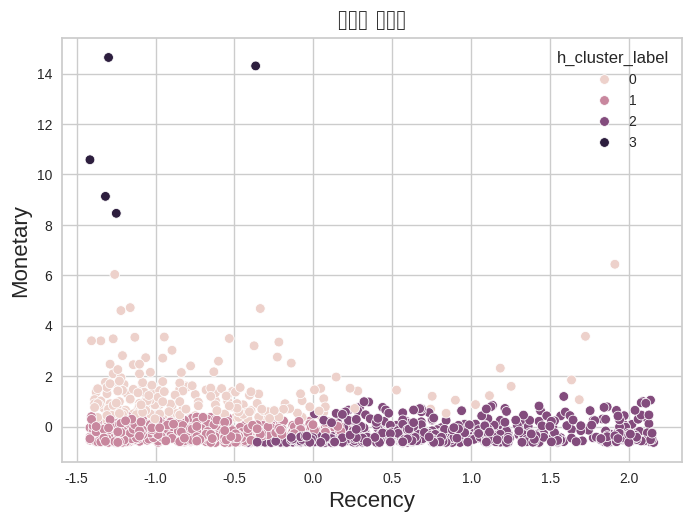

In [98]:
h_cluster = AgglomerativeClustering(n_clusters=4, affinity='euclidean', linkage = 'ward').fit(rfm_core.iloc[:, :3])

rfm_core['h_cluster_label'] = h_cluster.labels_

sns.scatterplot(data = rfm_core, x='Recency', y='Monetary', hue='h_cluster_label')
plt.title('계층적 군집화', fontsize=20)
plt.xlabel('Recency', fontsize=16)
plt.ylabel('Monetary', fontsize=16)

In [99]:

rfm_pca2['kmeans_labels'] = rfm_core['kmeans_labels']
rfm_pca2['dbscan_labels'] = rfm_core['dbscan_labels']
rfm_pca2['h_cluster_label'] = rfm_core['h_cluster_label']

Text(0, 0.5, 'pca2')

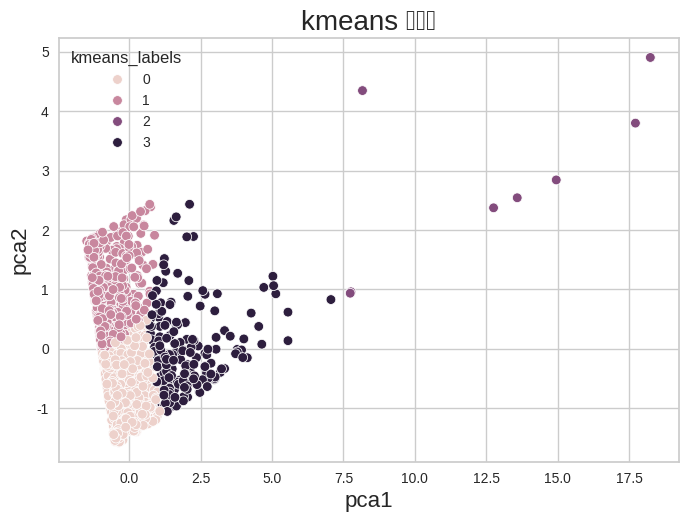

In [100]:
sns.scatterplot(data = rfm_pca2, x='pca1', y='pca2', hue='kmeans_labels')
plt.title('kmeans 군집화', fontsize=20)
plt.xlabel('pca1', fontsize=16)
plt.ylabel('pca2', fontsize=16)

Text(0, 0.5, 'pca2')

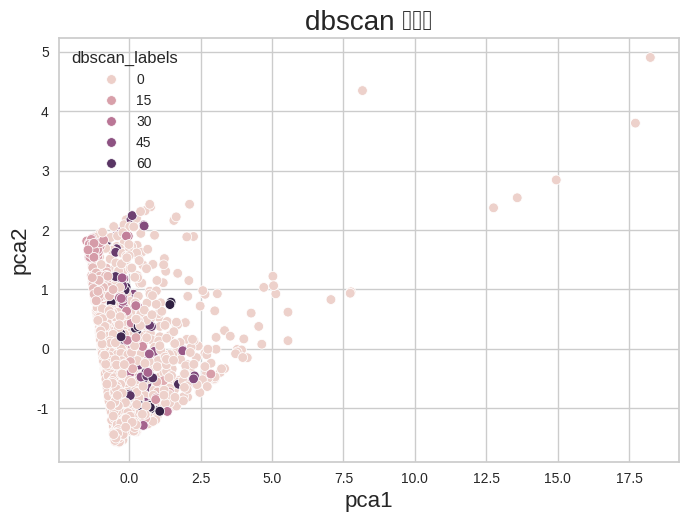

In [101]:
sns.scatterplot(data = rfm_pca2, x='pca1', y='pca2', hue='dbscan_labels')
plt.title('dbscan 군집화', fontsize=20)
plt.xlabel('pca1', fontsize=16)
plt.ylabel('pca2', fontsize=16)

Text(0, 0.5, 'pca2')

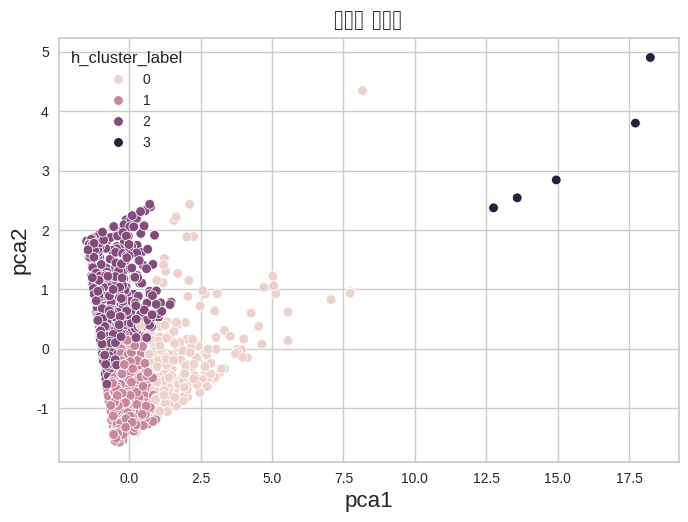

In [102]:
sns.scatterplot(data = rfm_pca2, x='pca1', y='pca2', hue='h_cluster_label')
plt.title('계층적 군집화', fontsize=20)
plt.xlabel('pca1', fontsize=16)
plt.ylabel('pca2', fontsize=16)

In [103]:
tsne = TSNE(n_components=2)

rfm_tsne = pd.DataFrame(data=tsne.fit_transform(rfm_core.iloc[:, :3]), columns=['col1', 'col2'])

rfm_tsne['kmeans_labels'] = rfm_core['kmeans_labels']
rfm_tsne['dbscan_labels'] = rfm_core['dbscan_labels']
rfm_tsne['h_cluster_label'] = rfm_core['h_cluster_label']

Text(0, 0.5, 'col2')

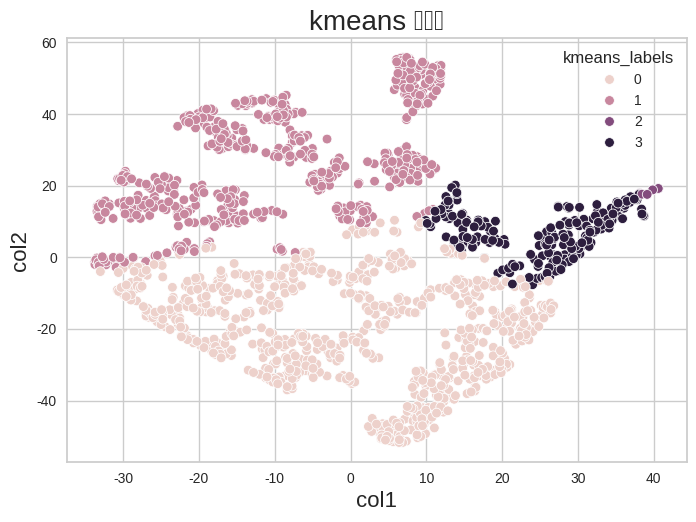

In [104]:
sns.scatterplot(data = rfm_tsne, x='col1', y='col2', hue='kmeans_labels')
plt.title('kmeans 군집화', fontsize=20)
plt.xlabel('col1', fontsize=16)
plt.ylabel('col2', fontsize=16)

Text(0, 0.5, 'col2')

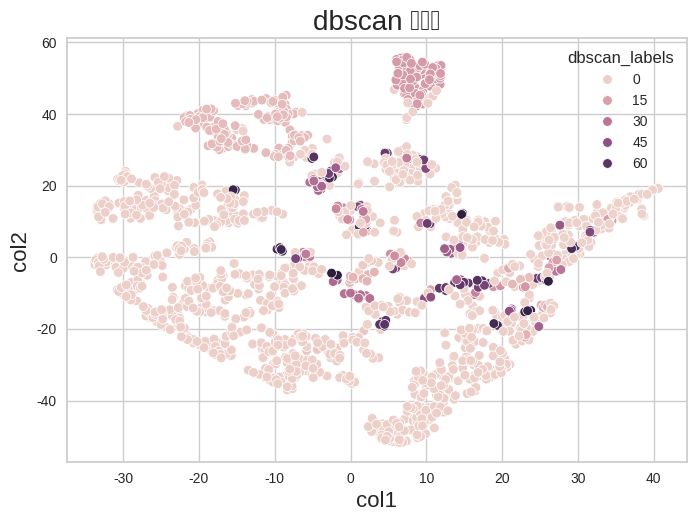

In [105]:
sns.scatterplot(data = rfm_tsne, x='col1', y='col2', hue='dbscan_labels')
plt.title('dbscan 군집화', fontsize=20)
plt.xlabel('col1', fontsize=16)
plt.ylabel('col2', fontsize=16)

Text(0, 0.5, 'col2')

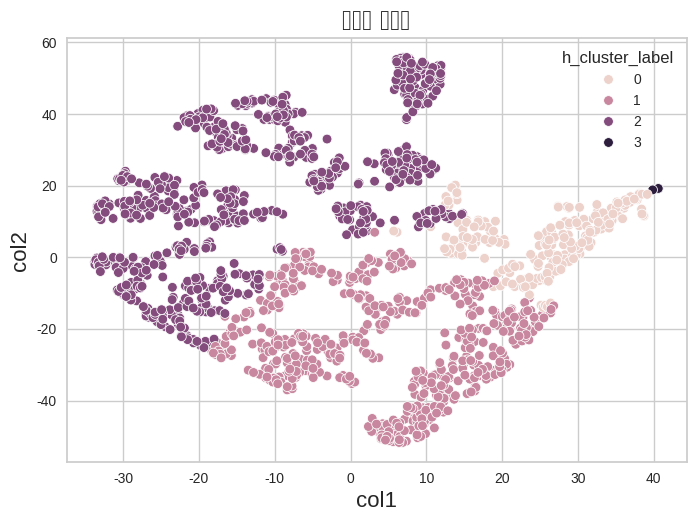

In [106]:
sns.scatterplot(data = rfm_tsne, x='col1', y='col2', hue='h_cluster_label')
plt.title('계층적 군집화', fontsize=20)
plt.xlabel('col1', fontsize=16)
plt.ylabel('col2', fontsize=16)

1. EDA(원본 데이터)
2. 유저데이터 변환 - RFM 분석의 지표를 차용함
4. 클러스터 수 선정 kmeans(init=random)metric=3가지로 했을 때 k=4가 나와서
3. 클러스터링 기법 선정
    - kmeans
    - dbscan: 데이터가 기하학적인 분포가 존재한다고 할 수 없고
      데이터가 밀도가 과도하게 높은 지점이 존재하기 때문에 지나친 양분화로 인해 탈락

    - 계층적 군집화 : 지표로 사용한 RFM 분석에서 cut을 사용하는 것과 유사하게
      트리구조의 개념으로 분류하는 것이라서 적합해보임


### EDA

In [107]:
##### 비즈니스 인사이트 테이블

In [108]:
#### ROAS 지표

df.head()

고객ID              거래ID       거래날짜          제품ID    제품카테고리  수량    평균금액  \
0  USER_1358  Transaction_0000 2019-01-01  Product_0981  Nest-USA   1  153.71   
1  USER_1358  Transaction_0001 2019-01-01  Product_0981  Nest-USA   1  153.71   
2  USER_1358  Transaction_0002 2019-01-01  Product_0904    Office   1    2.05   
3  USER_1358  Transaction_0003 2019-01-01  Product_0203   Apparel   5   17.53   
4  USER_1358  Transaction_0003 2019-01-01  Product_0848      Bags   1   16.50   

   배송료      쿠폰상태 성별     고객지역  가입기간   GST    월    쿠폰코드   할인율  오프라인비용   온라인비용  \
0  6.5      Used  남  Chicago    12  0.10  Jan  ELEC10  10.0    4500  2424.5   
1  6.5      Used  남  Chicago    12  0.10  Jan  ELEC10  10.0    4500  2424.5   
2  6.5      Used  남  Chicago    12  0.10  Jan   OFF10  10.0    4500  2424.5   
3  6.5  Not Used  남  Chicago    12  0.18  Jan  SALE10  10.0    4500  2424.5   
4  6.5      Used  남  Chicago    12  0.18  Jan   AIO10  10.0    4500  2424.5   

   true_discount     평균배송료     납세액         총금액  real_discount  df총할인금액  
0              1  6.500000  15.371  160.210000           10.0   15.371  
1              1  6.500000  15.371  160.210000           10.0   15.371  
2              1  6.500000   0.205    8.550000           10.0    0.205  
3              0  1.083333  15.777  104.510333            0.0    0.000  
4              1  1.083333   2.970   18.903333           10.0    1.650

In [109]:
df['총마케팅비용'] = df['오프라인비용'] + df['온라인비용']
df['ma_total_marketing'] = df['총마케팅비용'].rolling(7).mean().fillna(method='bfill')
df

고객ID               거래ID       거래날짜          제품ID    제품카테고리  수량  \
0      USER_1358   Transaction_0000 2019-01-01  Product_0981  Nest-USA   1   
1      USER_1358   Transaction_0001 2019-01-01  Product_0981  Nest-USA   1   
2      USER_1358   Transaction_0002 2019-01-01  Product_0904    Office   1   
3      USER_1358   Transaction_0003 2019-01-01  Product_0203   Apparel   5   
4      USER_1358   Transaction_0003 2019-01-01  Product_0848      Bags   1   
...          ...                ...        ...           ...       ...  ..   
52919  USER_0504  Transaction_25056 2019-12-31  Product_0976  Nest-USA   1   
52920  USER_0504  Transaction_25057 2019-12-31  Product_0413   Apparel   1   
52921  USER_0504  Transaction_25058 2019-12-31  Product_0989  Nest-USA   1   
52922  USER_0562  Transaction_25059 2019-12-31  Product_0985  Nest-USA   5   
52923  USER_0562  Transaction_25060 2019-12-31  Product_0984  Nest-USA   4   

         평균금액    배송료      쿠폰상태 성별        고객지역  가입기간   GST    월    쿠폰코드   할인율  \
0      153.71   6.50      Used  남     Chicago    12  0.10  Jan  ELEC10  10.0   
1      153.71   6.50      Used  남     Chicago    12  0.10  Jan  ELEC10  10.0   
2        2.05   6.50      Used  남     Chicago    12  0.10  Jan   OFF10  10.0   
3       17.53   6.50  Not Used  남     Chicago    12  0.18  Jan  SALE10  10.0   
4       16.50   6.50      Used  남     Chicago    12  0.18  Jan   AIO10  10.0   
...       ...    ...       ... ..         ...   ...   ...  ...     ...   ...   
52919  121.30   6.50   Clicked  여    New York    45  0.10  Dec  ELEC30  30.0   
52920   48.92   6.50      Used  여    New York    45  0.18  Dec  SALE30  30.0   
52921  151.88   6.50      Used  여    New York    45  0.10  Dec  ELEC30  30.0   
52922   80.52   6.50   Clicked  여  California     7  0.10  Dec  ELEC30  30.0   
52923   80.52  19.99   Clicked  여  California     7  0.10  Dec  ELEC30  30.0   

       오프라인비용    온라인비용  true_discount      평균배송료      납세액         총금액  \
0        4500  2424.50              1   6.500000  15.3710  160.210000   
1        4500  2424.50              1   6.500000  15.3710  160.210000   
2        4500  2424.50              1   6.500000   0.2050    8.550000   
3        4500  2424.50              0   1.083333  15.7770  104.510333   
4        4500  2424.50              1   1.083333   2.9700   18.903333   
...       ...      ...            ...        ...      ...         ...   
52919    4000  2058.75              0   6.500000  12.1300  139.930000   
52920    4000  2058.75              1   6.500000   8.8056   49.549600   
52921    4000  2058.75              1   6.500000  15.1880  128.004000   
52922    4000  2058.75              0   6.500000  40.2600  449.360000   
52923    4000  2058.75              0  19.990000  32.2080  374.278000   

       real_discount  df총할인금액   총마케팅비용  ma_total_marketing  
0               10.0   15.371  6924.50             6924.50  
1               10.0   15.371  6924.50             6924.50  
2               10.0    0.205  6924.50             6924.50  
3                0.0    0.000  6924.50             6924.50  
4               10.0    1.650  6924.50             6924.50  
...              ...      ...      ...                 ...  
52919            0.0    0.000  6058.75             6058.75  
52920           30.0   14.676  6058.75             6058.75  
52921           30.0   45.564  6058.75             6058.75  
52922            0.0    0.000  6058.75             6058.75  
52923            0.0    0.000  6058.75             6058.75  

[52924 rows x 26 columns]

In [110]:
marketing = df[['거래날짜', '총마케팅비용']].drop_duplicates().reset_index(drop=True)

marketing2 = df[['거래날짜', '총마케팅비용']].drop_duplicates().reset_index(drop=True)
marketing2['ma_total_marketing'] = marketing2['총마케팅비용'].rolling(7).mean().fillna(method='bfill')
marketing2 = marketing2.rename(columns={'ma_total_marketing':'총마케팅비용(7일ma)'})
marketing2

거래날짜   총마케팅비용  총마케팅비용(7일ma)
0   2019-01-01  6924.50   7477.351429
1   2019-01-02  7980.36   7477.351429
2   2019-01-03  6076.38   7477.351429
3   2019-01-04  7428.55   7477.351429
4   2019-01-05  8555.30   7477.351429
..         ...      ...           ...
360 2019-12-27  7396.87   6754.795714
361 2019-12-28  7246.84   6702.525714
362 2019-12-29  6546.58   6664.971429
363 2019-12-30  4674.31   6375.631429
364 2019-12-31  6058.75   6134.101429

[365 rows x 3 columns]

In [111]:
sales = df.groupby('거래날짜')['총금액'].sum().reset_index()
sales

거래날짜         총금액
0   2019-01-01   8389.5816
1   2019-01-02  14967.0770
2   2019-01-03  27206.2101
3   2019-01-04  18768.6781
4   2019-01-05  20104.2152
..         ...         ...
360 2019-12-27  14209.5811
361 2019-12-28  11014.3226
362 2019-12-29  12276.2817
363 2019-12-30   8397.3965
364 2019-12-31  10716.6735

[365 rows x 2 columns]

In [112]:
roas1 = pd.merge(marketing, sales, how='left', on='거래날짜')
roas1['ratio'] = roas1['총금액'] / roas1['총마케팅비용']
roas1.sort_values('ratio', ascending=False).head(10)

거래날짜   총마케팅비용         총금액      ratio
150 2019-05-31  1510.30  23770.4291  15.738879
29  2019-01-30  1681.86  21349.3265  12.693879
94  2019-04-05  4842.68  59088.7803  12.201669
151 2019-06-01   820.25   9678.5838  11.799554
31  2019-02-01  1392.67  16000.5043  11.489085
23  2019-01-24  1560.02  16505.0998  10.580057
213 2019-08-02  3655.96  37909.3386  10.369189
30  2019-01-31  2080.14  21020.9349  10.105539
149 2019-05-30  1762.38  17584.7791   9.977859
107 2019-04-18  5476.58  53397.6890   9.750189

In [113]:
roas2 = pd.merge(marketing2, sales, how='left', on='거래날짜')
roas2['ratio'] = roas2['총금액'] / roas2['총마케팅비용(7일ma)']
roas2.sort_values('ratio', ascending=False).head(10)


거래날짜   총마케팅비용  총마케팅비용(7일ma)         총금액      ratio
94  2019-04-05  4842.68   4289.407143  59088.7803  13.775512
29  2019-01-30  1681.86   1788.870000  21349.3265  11.934532
213 2019-08-02  3655.96   3241.630000  37909.3386  11.694530
30  2019-01-31  2080.14   1863.172857  21020.9349  11.282332
330 2019-11-27  5819.58   5001.338571  55439.0730  11.084847
150 2019-05-31  1510.30   2243.272857  23770.4291  10.596316
198 2019-07-18  4408.61   3999.448571  41761.8631  10.441905
107 2019-04-18  5476.58   5430.738571  53397.6890   9.832491
31  2019-02-01  1392.67   1758.561429  16000.5043   9.098633
32  2019-02-02  1470.87   1691.888571  13779.3542   8.144363

<Axes: xlabel='거래날짜', ylabel='ratio'>

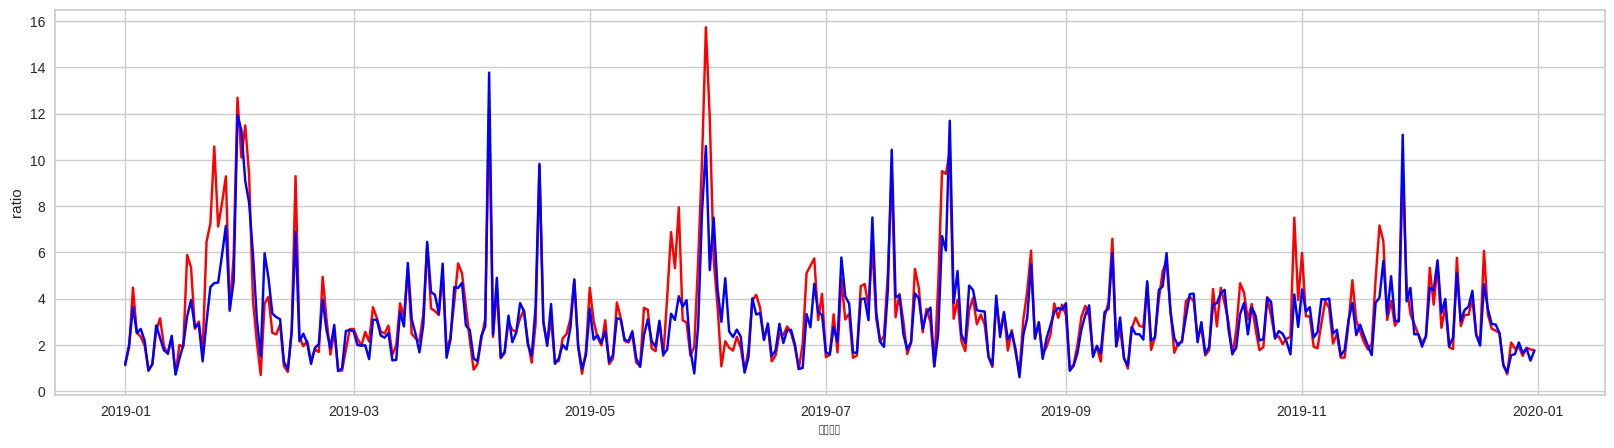

In [114]:
plt.figure(figsize=(20, 5))
sns.lineplot(data=roas1, x='거래날짜', y='ratio', color='red')
sns.lineplot(data=roas2, x='거래날짜', y='ratio', color='blue')


# ratio(빨강) = 총비용 / 총마케팅비용
# ratio(파랑) = 총비용 / 총마케팅비용(이동평균)

# 총마케팅비용(이동평균) - 원본의 고점을 낮게 만드는 효과

# 마케팅의 특성상 직관적으로 볼때는 이동평균을 하는게 맞아보이는데


In [115]:
week = []
cut = 0


for i in range(1, 54):
    for j in range(7):
        week.append(i)
        if len(week) == len(roas1):
            break
    if len(week) == len(roas1):
        break

roas1['week'] = np.array(week).reshape(len(roas1), -1)
roas1

거래날짜   총마케팅비용         총금액     ratio  week
0   2019-01-01  6924.50   8389.5816  1.211579     1
1   2019-01-02  7980.36  14967.0770  1.875489     1
2   2019-01-03  6076.38  27206.2101  4.477371     1
3   2019-01-04  7428.55  18768.6781  2.526560     1
4   2019-01-05  8555.30  20104.2152  2.349914     1
..         ...      ...         ...       ...   ...
360 2019-12-27  7396.87  14209.5811  1.921026    52
361 2019-12-28  7246.84  11014.3226  1.519879    52
362 2019-12-29  6546.58  12276.2817  1.875221    52
363 2019-12-30  4674.31   8397.3965  1.796500    52
364 2019-12-31  6058.75  10716.6735  1.768793    53

[365 rows x 5 columns]

In [116]:
week_core = pd.DataFrame(roas1.groupby('week')[['총마케팅비용', '총금액']].sum()).reset_index()
week_core['ratio_week'] = week_core['총금액'] / week_core['총마케팅비용']
week_core.sort_values('ratio_week', ascending=False).head(10)

week    총마케팅비용          총금액  ratio_week
21    22  10081.86   77987.7588    7.735453
3      4  13710.42  100285.4809    7.314545
4      5  13870.26   98204.4768    7.080219
30    31  21959.29  127391.8228    5.801272
28    29  28218.83  117955.2384    4.180019
46    47  33355.78  137593.1222    4.125016
47    48  37320.98  152192.1311    4.077924
20    21  18022.79   72792.0879    4.038891
13    14  31863.55  126414.3853    3.967367
11    12  26066.40  101540.6453    3.895461

<Axes: xlabel='week', ylabel='총마케팅비용'>

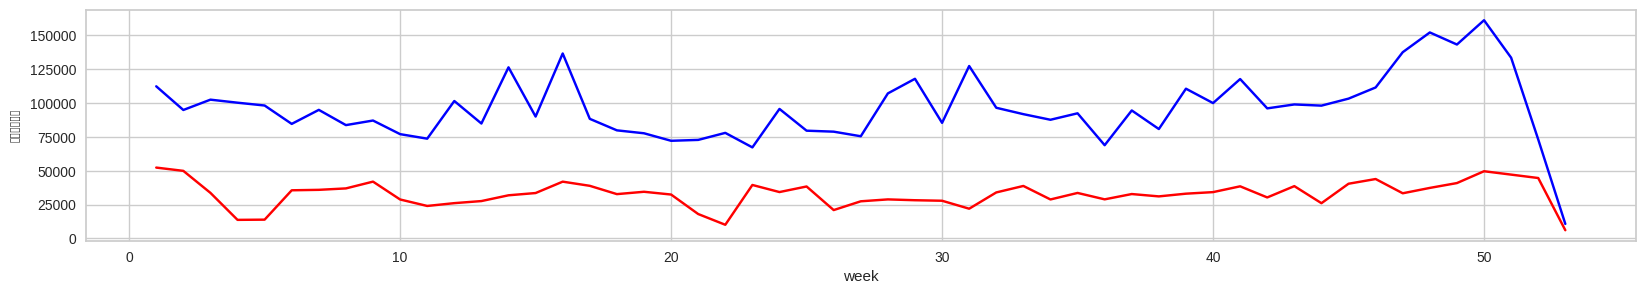

In [117]:
plt.figure(figsize=(20, 3))
sns.lineplot(data=week_core, x='week', y='총마케팅비용', color='red')
sns.lineplot(data=week_core, x='week', y='총금액', color='blue')


<Axes: xlabel='week', ylabel='ratio_week'>

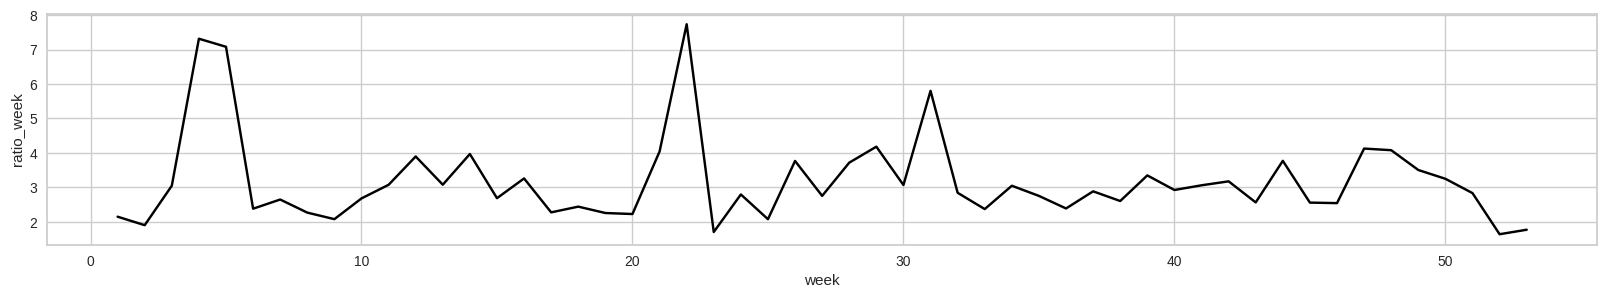

In [118]:
plt.figure(figsize=(20, 3))
sns.lineplot(data=week_core, x='week', y='ratio_week', color='black')